# VAE Using Extended Kalman Filter for Speech Recognition using TIMIT  

The purpose of this demo is to help you learn about variational autoencoder. The algorithm is being implemented is from the paper "Auto-Encoding Variational Bayes", by Diederik P Kingma, Max Welling (https://arxiv.org/abs/1312.6114).

Followed the logic:
VAE: https://github.com/ethanluoyc/pytorch-vae/blob/master/vae.py 

TIMIT: https://github.com/jackjhliu/Pytorch-End-to-End-ASR-on-TIMIT

EKF: https://github.com/jnez71/kalmaNN

We are using TIMIT data.

You are free to change model acrhitecture, or any part of the logic. 

If you have any suggestions or find errors, please, don't be hesitate to text me at jayanta.jayantamukherjee@gmail.com

In [1]:
import argparse
import data
import eval_utils
import logging, sys
import matplotlib.pyplot as plt
import os
from prepare_data import prepare_csv
from show_history import plotLearning
import time 
import timeit
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torchvision
from torchvision import transforms
import torch.optim as optim
import yaml

/home/jay/.conda/envs/jay/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Prepare Data from Raw WAV files: TIMIT


In [2]:
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

prepare_csv("../TIMIT/TIMIT_DATA/")

TRAIN.csv is created.
DEV.csv is created.
TEST.csv is created.
Data preparation is complete !


## MultiLayer GRUCell

In [3]:
class MultiLayerGRUCell(nn.Module):
    """
    Stack multiple GRU cells. For DecoderRNN.
    """
    def __init__(self, input_size, hidden_size, num_layers, drop_p):
        """
        Args:
            input_size (integer): Input size of GRU cells.
            hidden_size (integer): Hidden layer size of GRU cells.
            num_layers (integer): Number of GRU layers.
            drop_p (float): Probability to drop elements at Dropout layers.
        """
        super(MultiLayerGRUCell, self).__init__()

        self.cells = nn.ModuleList([])
        for i in range(num_layers):
            if i==0:
                self.cells.append(nn.GRUCell(input_size, hidden_size))
            else:
                self.cells.append(nn.GRUCell(hidden_size, hidden_size))
        self.dropouts = nn.ModuleList([nn.Dropout(drop_p) for _ in range(num_layers-1)])
        self.num_layers = num_layers

    def forward(self, x, h):
        """
        One step forward pass.
        
        Args:
            x (torch.FloatTensor, [batch_size, input_size]): The input features of current time step.
            h (torch.FloatTensor, [num_layers, batch_size, hidden_size]): The hidden state of previous time step.
            
        Returns:
            outputs (torch.FloatTensor, [num_layers, batch_size, hidden_size]): The hidden state of current time step.
        """
        outputs = []
        for i in range(self.num_layers):
            if i==0:
                x = self.cells[i](x, h[i])
            else:
                x = self.cells[i](self.dropouts[i-1](x), h[i])
            outputs.append(x)
        outputs = torch.stack(outputs, dim=0)
        return outputs

#### Load Config & Clean up Previous Run Stats

In [4]:
cfgFile = "config/default.yaml" 
import shutil

with open(cfgFile) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
        
if not cfg['logdir']:
    save_path = os.path.splitext(cfgFile)[0]
    
if os.path.exists(save_path):
    shutil.rmtree(save_path)

os.mkdir(save_path)

### Set the constants

In [5]:
gpu_id = 0
workers = 0
ckpt_freq = 10

### Encoder  RNN

D_in: Input Dimension
H: 
D_out: Output Dimension

In [6]:
class EncoderRNN(nn.Module):
    """
    A bidirectional RNN. It takes FBANK features and outputs the output state vectors of every time step.
    """
    def __init__(self, n_words, hidden_size, num_layers, drop_p):
        """
        Args:
            hidden_size (integer): Size of GRU cells.
            num_layers (integer): Number of GRU layers.
            drop_p (float): Probability to drop elements at Dropout layers.
        """
        super(EncoderRNN, self).__init__()
        self.embed = nn.Linear(n_words, hidden_size)   # 240 is the dimension of acoustic features.
        self.rnn = nn.GRU(hidden_size,
                          hidden_size,
                          batch_first=True,
                          bidirectional=True,
                          num_layers=num_layers,
                          dropout=drop_p)
        # The initial state is a trainable vector.
        self.init_state = torch.nn.Parameter(torch.randn([2 * num_layers, 1, hidden_size]))

    def forward(self, xs, xlens):
        """
        We pack the padded sequences because it is especially important for bidirectional RNN to work properly. The RNN 
        in opposite direction can ignore the first few <PAD> tokens after packing.

        Args:
            xs (torch.FloatTensor, [batch_size, seq_length, dim_features]): A mini-batch of FBANK features.
            xlens (torch.LongTensor, [batch_size]): Sequence lengths before padding.

        Returns:
            outputs (PackedSequence): The packed output states.
        """
        #print("EncoderRNN forward")
        batch_size = xs.shape[0]
        xs = self.embed(xs)
        xs = rnn_utils.pack_padded_sequence(xs,
                                            xlens,
                                            batch_first=True,
                                            enforce_sorted=False)
        outputs, _ = self.rnn(xs, self.init_state.repeat([1, batch_size, 1]))
        #print("EncoderRNN outputs = ", outputs)
        return outputs

### Decoder RNN

In [7]:
class DecoderRNN(nn.Module):
    """
    A decoder network which applies Luong attention (https://arxiv.org/abs/1508.04025).
    """
    def __init__(self, n_words, hidden_size, num_layers, activation, drop_p):
        """
        Args:
            n_words (integer): Size of the target vocabulary.
            hidden_size (integer): Size of GRU cells.
            num_layers (integer): Number of GRU layers.
            activation: activation function type; 'logistic', 'tanh', or 'relu'
            drop_p (float): Probability to drop elements at Dropout layers.
        """
        super(DecoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.embed = nn.Embedding(n_words, hidden_size)
        self.cell = MultiLayerGRUCell(2 * hidden_size,
                                      hidden_size,
                                      num_layers=num_layers,
                                      drop_p=drop_p)
        # The initial states are trainable vectors.
        self.init_h = torch.nn.Parameter(torch.randn([num_layers, 1, hidden_size]))
        self.init_y = torch.nn.Parameter(torch.randn([1, hidden_size]))

        self.attn_W = nn.Linear(2 * hidden_size, hidden_size)
        self.attn_U = nn.Linear(hidden_size, hidden_size)
        self.attn_v = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(3 * hidden_size, hidden_size)
        self.drop = nn.Dropout(drop_p)
        self.classifier = nn.Linear(hidden_size, n_words)
        self.activation = activation

    def forward(self, encoder_states, ground_truths=None):
        """
        The forwarding behavior depends on if ground-truths are provided.

        Args:
            encoder_states (PackedSequence): Packed output state vectors from the EncoderRNN.
            ground_truths (torch.LongTensor, [batch_size, padded_len_tgt]): Padded ground-truths.

        Returns:
            * When ground-truths are provided, it returns cross-entropy loss. Otherwise it returns predicted word IDs
            and the attention weights.
            loss (float): The cross-entropy loss to maximizing the probability of generating ground-truths.
            predictions (torch.FloatTensor, [batch_size, max_length]): The sentence generated by Greedy Search.
            all_attn_weights (torch.FloatTensor, [batch_size, max_length, length_of_encoder_states]): A list contains
                attention alignment weights for the predictions.
        """
        #print("DecoderRNN forward")
        states, states_lengths  = rnn_utils.pad_packed_sequence(
            encoder_states, batch_first=True)   # [batch_size, padded_len_src, 2 * hidden_size], [batch_size]
        batch_size = states.shape[0]
        h = self.init_h.repeat([1, batch_size, 1])   # [num_layers, batch_size, hidden_size]
        y = self.init_y.repeat([batch_size, 1])      # [batch_size, hidden_size]

        if ground_truths is None:
            all_attn_weights = []
            predictions = [torch.full([batch_size], 3, dtype=torch.int64).cuda()]   # The first predicted word is always <s> (ID=3).
            # Unrolling the forward pass
            for time_step in range(100):   # Empirically set max_length=100
                x = predictions[-1]                           # [batch_size]
                x = self.embed(x)                             # [batch_size, hidden_size]
                h = self.cell(torch.cat([y, x], dim=-1), h)   # [num_layers, batch_size, hidden_size]
                attns, attn_weights = self.apply_attn(
                    states, states_lengths, h[-1])            # [batch_size, 2 * hidden_size], [batch_size, length_of_encoder_states]
                y = torch.cat([attns, h[-1]], dim=-1)         # [batch_size, 3 * hidden_size]
                y = self.apply_activation(self.activation, self.fc(y))                        # [batch_size, hidden_size]

                all_attn_weights.append(attn_weights)
                # Output
                logits = self.classifier(y)                   # [batch_size, n_words]
                samples = torch.argmax(logits, dim=-1)        # [batch_size]
                predictions.append(samples)
            all_attn_weights = torch.stack(all_attn_weights, dim=1)   # [batch_size, max_length, length_of_encoder_states]
            predictions = torch.stack(predictions, dim=-1)    # [batch_size, max_length]
            #print("DecoderRNN predictions = ", predictions)
            return predictions, all_attn_weights
        else:
            xs = self.embed(ground_truths[:, :-1])   # [batch_size, padded_len_tgt, hidden_size]
            outputs = []
            # Unrolling the forward pass
            for time_step in range(xs.shape[1]):
                h = self.cell(torch.cat([y, xs[:,time_step]], dim=-1), h)   # [num_layers, batch_size, hidden_size]
                attns, _ = self.apply_attn(states, states_lengths, h[-1])   # [batch_size, 2 * hidden_size]
                y = torch.cat([attns, h[-1]], dim=-1)                       # [batch_size, 3 * hidden_size]
                y = self.apply_activation(self.activation, self.fc(y))      # [batch_size, hidden_size]
                outputs.append(y)

            # Output
            outputs = torch.stack(outputs, dim=1)   # [batch_size, padded_len_tgt, hidden_size]
            outputs = self.drop(outputs)
            outputs = self.classifier(outputs)      # [batch_size, padded_len_tgt, n_words]
            #print("DecoderRNN outputs = ", outputs)
            

            # Compute loss
            mask = ground_truths[:, 1:].gt(0)       # [batch_size, padded_len_tgt]
            loss = nn.CrossEntropyLoss()(outputs[mask], ground_truths[:, 1:][mask])
            return loss

    def apply_attn(self, source_states, source_lengths, target_states):
        """
        Apply attention.

        Args:
            source_states (torch.FloatTensor, [batch_size, padded_length_of_encoder_states, 2 * hidden_size]):
                The padded encoder output states.
            source_lengths (torch.LongTensor, [batch_size]): The length of encoder output states before padding.
            target_state (torch.FloatTensor, [batch_size, hidden_size]): The decoder output state (of previous time step).

        Returns:
            attns (torch.FloatTensor, [batch_size, hidden_size]):
                The attention result (weighted sum of Encoder output states).
            attn_weights (torch.FloatTensor, [batch_size, padded_length_of_encoder_states]): The attention alignment weights.
        """
        # A two-layer network used for project every pair of [source_state, target_state].
        attns = self.attn_W(source_states) + self.attn_U(target_states).unsqueeze(1)   # [batch_size, padded_len_src, hidden_size]
        attns = self.attn_v(self.apply_activation(self.activation, attns)).squeeze(2)                   # [batch_size, padded_len_src]

        # Create a mask with shape [batch_size, padded_len_src] to ignore the encoder states with <PAD> tokens.
        mask = torch.arange(attns.shape[1]).unsqueeze(0).repeat([attns.shape[0], 1]).ge(source_lengths.unsqueeze(1))
        attns = attns.masked_fill_(mask.cuda(), -float('inf'))          # [batch_size, padded_len_src]
        attns = F.softmax(attns, dim=-1)                                # [batch_size, padded_len_src]
        attn_weights = attns.clone()
        attns = torch.sum(source_states * attns.unsqueeze(-1), dim=1)   # [batch_size, 2 * hidden_size]
        return attns, attn_weights
    
    def apply_activation(self, activation, y):
        # activation type
        if activation == 'logistic':
            return F.silu(y)
        elif activation == 'tanh':
            return F.tanh(y)
        elif activation == 'relu':
            return F.relu(y)
        else:
            raise ValueError("The neuron argument must be 'logistic', 'tanh', or 'relu'.")
        

## Kalman VAE

In [8]:
class KalmanVAE(torch.nn.Module):
    """
    Kalman VAE based on Sequence-to-sequence model made up of an EncoderRNN module and a DecoderRNN module 
    which leverage Extended Kalman Filter.
    """
    def __init__(self, input_size, target_size, hidden_size, encoder_layers, decoder_layers, activation, sprW=5, drop_p=0.):
        """
        Args:
            target_size (integer): Target vocabulary size.
            hidden_size (integer): Size of GRU cells: number of hidden-layer neurons
            encoder_layers (integer): EncoderRNN layers: Dimensionality of Input
            decoder_layers (integer): DecoderRNN layers: Dimensionality of Output
            activation: activation function type; 'logistic', 'tanh', or 'relu'
            sprW: spread of initial randomly sampled synapse weights; float scalar
            drop_p (float): Probability to drop elements at Dropout layers.
        """
        super(KalmanVAE, self).__init__()
        #print("Init KalmanVAE")
        # Create two identical KNN's that will be trained differently
        self.activation = activation
        self.hidden_size = hidden_size
        logging.debug("input_size = ", input_size, ", target_size = ", target_size)
        self.encoder = EncoderRNN(input_size, hidden_size, encoder_layers, drop_p)
        self.decoder = DecoderRNN(target_size, hidden_size, decoder_layers, self.activation, drop_p)  
        self.embed = nn.Linear(input_size, hidden_size) 

    def forward(self, xs, xlens, ys=None):
        """
        The forwarding behavior depends on if ground-truths are provided.

        Args:
            xs (torch.LongTensor, [batch_size, seq_length, dim_features]): A mini-batch of FBANK features.
            xlens (torch.LongTensor, [batch_size]): Sequence lengths before padding.
            ys (torch.LongTensor, [batch_size, padded_length_of_target_sentences]): Padded ground-truths.

        Returns:
            * When ground-truths are provided, it returns cross-entropy loss. Otherwise it returns predicted word IDs
            and the attention weights.
            loss (float): The cross-entropy loss to maximizing the probability of generating ground-truth.
            predictions (torch.FloatTensor, [batch_size, max_length]): The sentence generated by Greedy Search.
            attn_weights (torch.FloatTensor, [batch_size, max_length, length_of_encoder_states]): A list contains
                attention alignment weights for the predictions.
        """
        #print("VAE forward")
        if ys is None:
            predictions, attn_weights = self.decoder(self.encoder(xs, xlens))
            return predictions, attn_weights
        else:
            loss = self.decoder(self.encoder(xs, xlens), ys)
            return loss

            
    def get_lr(self, optimizer):
        """
        A helper function to retrieve the solver's learning rate.
        """
        for param_group in optimizer.param_groups:
            return param_group['lr']


    def log_history(self, save_path, message):
        """
        A helper function to log the history.
        The history text file is saved as: {SAVE_PATH}/history.txt

        Args:
            save_path (string): The location to log the history.
            message (string): The message to log.
        """
        fname = os.path.join(save_path,'history.csv')
        if not os.path.exists(fname):
            with open(fname, 'w') as f:
                f.write("datetime,epoch,learning rate,train loss,dev loss,error rate\n")
                f.write("%s\n" % message)
        else:
            with open(fname, 'a') as f:
                f.write("%s\n" % message)


    def save_checkpoint(self, filename, save_path, epoch, dev_error, cfg, weights):
        """
        Args:
            filename (string): Filename of this checkpoint.
            save_path (string): The location to save.
            epoch (integer): Epoch number.
            dev_error (float): Error rate on development set.
            cfg (dict): Experiment config for reconstruction.
            weights (dict): "state_dict" of this model.
        """
        filename = os.path.join(save_path, filename)
        info = {'epoch': epoch,
                'dev_error': dev_error,
                'cfg': cfg,
                'weights': weights}
        torch.save(info, filename) 


## Kalman Neural Network: 

Reference: https://github.com/jnez71/kalmaNN/blob/master/kalmann/knn.py

In [9]:
import numpy as np; npl = np.linalg
from scipy.linalg import block_diag

class KNN:
    """
    Class for a feedforward neural network (NN). Currently only handles 1 hidden-layer,
    is always fully-connected, and uses the same activation function type for every neuron.
    The NN can be trained by extended kalman filter (EKF) or stochastic gradient descent (SGD).
    Use the train function to train the NN, the feedforward function to compute the NN output,
    and the classify function to round a feedforward to the nearest class values. A save function
    is also provided to store a KNN object in the working directory.
    """
    def __init__(self, nu, ny, nl, neuron, sprW=5):
        """
            nu: dimensionality of input; positive integer
            ny: dimensionality of output; positive integer
            nl: number of hidden-layer neurons; positive integer
        neuron: activation function type; 'logistic', 'tanh', or 'relu'
          sprW: spread of initial randomly sampled synapse weights; float scalar
        """
        # Function dimensionalities
        self.nu = int(nu)
        self.ny = int(ny)
        self.nl = int(nl)

        # Neuron type
        if neuron == 'logistic':
            self.sig = lambda V: (1 + np.exp(-V))**-1
            self.dsig = lambda sigV: sigV * (1 - sigV)
        elif neuron == 'tanh':
            self.sig = lambda V: np.tanh(V)
            self.dsig = lambda sigV: 1 - sigV**2
        elif neuron == 'relu':
            self.sig = lambda V: np.clip(V, 0, np.inf)
            self.dsig = lambda sigV: np.float64(sigV > 0)
        else:
            raise ValueError("The neuron argument must be 'logistic', 'tanh', or 'relu'.")
        self.neuron = neuron

        # Initial synapse weight matrices
        self.sprW = np.float64(sprW)
        logging.debug("nu = ", nu, ", ny = ", ny, ", nl = ", nl, ", sprW = ", sprW)
        
        self.reinit_stats(nu, ny, nl)

        # Function for pushing signals through a synapse with bias
        self._affine_dot2 = lambda W, V: np.dot(np.atleast_1d(V.T), W[:, :].T).T # + W[:, 0]
        # Function for pushing signals through a synapse with bias
        self._affine_dot = lambda W, V: np.dot(np.atleast_1d(V.T), W[:, :-1].T).T # + W[:, -1]
        
        # Function for computing the RMS error of the current fit to some data set
        self.compute_rms_sq = lambda U, Y: np.square(Y[:, -1] - self.feedforward(U)[:, -1, -1]) 

        # Function for computing the RMS error of the current fit to some data set
        self.compute_rms = lambda U, Y: np.sqrt(np.mean((np.square(Y[:, -1] - self.feedforward(U)[:, -1, -1])),dtype=np.float64)) 

####

    def reinit_stats(self, nu, ny, nl):
        self.nu = int(nu)
        self.ny = int(ny)
        self.nl = int(nl)
        self.reinit_weights()
         
        
    def reinit_weights(self):
        logging.debug("reinit_weights: nu = ", self.nu, ", ny = ", self.ny, ", nl = ", self.nl)
        #W0 = self.sprW*(2*np.random.sample((self.nl, self.nu+1))-1)
        #W1 = self.sprW*(2*np.random.sample((self.ny, self.nl+1))-1)
        W0 = self.sprW*(2*np.random.sample((self.nl, self.nu))-1)
        W1 = self.sprW*(2*np.random.sample((self.ny, self.nl))-1)
        self.W = [W0, W1]
        logging.debug("W0.shape = ", W0.shape, "W1.shape = ", W1.shape)
        self.nW = len(self.W[1]) # sum(map(np.size, self.W))
        logging.debug("self.nW = ", self.nW)
        
####

    def save(self, filename):
        """
        Saves the current NN to a file with the given string filename.
        """
        if not isinstance(filename, str):
            raise ValueError("The filename must be a string.")
        if filename[-4:] != '.knn':
            filename = filename + '.knn'
        with open(filename, 'wb') as output:
            pickle.dump((self.W, self.neuron, self.P), output, pickle.HIGHEST_PROTOCOL)

####

    def classify(self, U, high, low=0):
        """
        Feeds forward an (m by nu) array of inputs U through the NN.
        For each associated output, the closest integer between high
        and low is returned as a (m by ny) classification matrix.
        Basically, your training data should be (u, int_between_high_low).
        """
        return np.int64(np.clip(np.round(self.feedforward(U), 0), low, high))

 
    
    def initPQR(self, P=None, Q=None, R=None):
        Iden = np.eye(self.ny)
        Zeros = np.zeros((self.ny, self.ny))
        #print("self.ny = ", self.ny) 
        if P is None:
            if self.P is None:
                self.P = np.multiply(P, Iden)
        elif np.isscalar(P):
            self.P = np.multiply(P, Iden)
        else:
            if np.shape(P) != (self.ny, self.ny):
                P = np.resize(P, (self.ny, self.ny))
            self.P = P

        logging.debug("if Q is None. ny = ", self.ny)
        if Q is None:
            logging.debug("self.Q ")
            self.Q = np.zeros((self.ny, self.ny))
            logging.debug("self.Q done")
        elif np.isscalar(Q):
            logging.debug("np.eye(self.ny) shape ", Iden.shape, "; Q = ", Q)
            if Q == 0:
                self.Q = Zeros
            else:
                print("Q*np.eye(self.ny) shape ", np.multiply(Q, Iden).shape)
                self.Q = np.multiply(Q, Iden)
            print("self.Q 2 done ")
        else:
            logging.debug("else ")
            if np.shape(Q) != (self.ny, self.ny):
                Q = np.resize(Q, (self.ny, self.ny))
            self.Q = Q
            
        logging.debug("if np.any(self.Q)")
        if np.any(self.Q): self.Q_nonzero = True
        else: self.Q_nonzero = False

        logging.debug("if R is None")
        if R is None:
            raise ValueError("R must be specified for EKF training.")
        elif np.isscalar(R):
            self.R = R*np.eye(self.ny)
        else:
            if np.shape(R) != (self.ny, self.ny):
                R = np.resize(R, (self.ny, self.ny))
                # np.dot(R, R.T) will generate positive definite matrix
                R = np.dot(R, R.T)
            self.R = R
        if npl.matrix_rank(self.R) != len(self.R):
            R = np.dot(R, R.T)

####

    def feedforward(self, U, get_l=False):
        """
        Feeds forward an (m by nu) array of inputs U through the NN.
        Returns the associated (m by ny) output matrix, and optionally
        the intermediate activations l.
        """
        if len(U) > self.nu: U = U[:, np.newaxis]
        l = self.sig(self._affine_dot2(self.W[0], U))
        logging.debug("l shape = ", l.shape)
        h = self._affine_dot2(self.W[1], l)
        logging.debug("h shape = ", h.shape)
        if get_l: return h, l
        return h
    
####

    def ekf(self, u, y, h, l, step, P=None, Q=None, R=None):
        self.initPQR(P, Q, R)
        logging.debug("shapes: u = ", u.shape, ", y =", y.shape, ", h = ", h.shape,", l.shape = ", l.shape)
        logging.debug("self.W[1][:, :] shape = ", self.W[1][:, :].shape, "self.W[1] shape = ", self.W[1].shape)
        logging.debug("self.dsig(l) shape = ", self.dsig(l).shape)
        # Compute NN jacobian
        # self.W[1][:, :-1] shape =  (64, 256)  self.dsig(l) shape =  (256, 192, 240)
        D = self._affine_dot2(self.W[1], self.dsig(l))  # flatten = 3394560
        logging.debug("post affine : D shape = ", D.shape)
        #time.sleep(1)
        # D = self.W[1][:, :-1] * self.dsig(l)
        logging.debug("D shape = ", D.shape, ", u shape = ", len(u), ", l shape = ", l.shape)
        d_size = self.ny * self.ny
        
        # As H is an arbitrary matrix, so, extract by flattening
        H = D.flatten()[:d_size].reshape(self.ny, self.ny) #np.hstack((D, u))
        one_array = np.ones((l.shape), order='C')
        l_concat = np.concatenate((l, one_array), axis=1)
        logging.debug("l_concat.shape = ", l_concat.shape)
        
        W0_len = len(self.W[0])
        W1_len = len(self.W[1])
        
        logging.debug("W0_len = ", W0_len, ", W1_len = ", W1_len, ", self.ny = ", self.ny)
        
        # Kalman gain
        S = H.dot(self.P).dot(H.T) + self.R
        logging.debug("S shape = ", S.shape)
        K = self.P.dot(H.T).dot(npl.inv(S))
        logging.debug("K shape = ", K.shape)

        self.P = self.P - np.dot(K, H.dot(self.P))
        logging.debug("self.P shape = ", self.P.shape)
        
        #print("H * h = ", H * h)
        # Update weight estimates and covariance
        y = np.resize(y, (self.ny, self.ny))
        self.P = self.P - np.dot(K, H.dot(self.P))
        logging.debug("y-H shape = ", (y - H).shape)
        dW = step*K.dot(y - H)
        logging.debug("dW shape = ", dW.shape)
        dW = np.resize(dW, 2 * self.W[0].size)
        logging.debug("After resize, dW shape = ", dW.shape)
        self.W[0] = self.W[0] + dW[:self.W[0].size].reshape(self.W[0].shape)
        self.W[1] = self.W[1] + dW[self.W[0].size:].reshape(self.W[1].shape)
        
        if np.any(self.Q): self.Q_nonzero = True
        else: self.Q_nonzero = False
            
        if self.Q_nonzero: self.P = self.P + self.Q
        return self.P, self.R

## Initialize Kalman VAE Model

In [10]:
#input_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = cfg['train']['batch_size']
#transform = transforms.Compose([transforms.ToTensor()])

# Create dataset
train_loader = data.load(split='train', batch_size=batch_size, workers = workers)
dev_loader = data.load(split='dev', batch_size=batch_size)
hidden_size = hidden_size=cfg['model']['hidden_size']
activation=cfg['model']['activation']

# Build model
tokenizer = torch.load('tokenizer.pth')
#print("tokenizer.vocab shape = ", tokenizer.vocab.shape)
model = KalmanVAE(input_size=cfg['model']['input_size'],
            target_size=len(tokenizer.vocab),
            hidden_size=cfg['model']['hidden_size'],
            encoder_layers=cfg['model']['encoder_layers'],
            decoder_layers=cfg['model']['decoder_layers'],
            activation=cfg['model']['activation'],
            drop_p=cfg['model']['drop_p'])
model = model.cuda() 

TRAIN set size: 3696
DEV set size: 1152


### Train the VAE

In [11]:
#model.train(cfg, save_path, gpu_id, workers, ckpt_freq, P=0.5, R=0.1) 

# Training criteria: define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(model.parameters(), lr=cfg['train']['init_lr'])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=cfg['train']['decay_factor'],
                                                       patience=cfg['train']['patience'],
                                                       min_lr=1e-6)

# Train
# Get some noisy training data, a fun compact function
stdev = 0.05
trcov = []
RMS = []
train_epoch_durations = []
eval_epoch_durations = []
P=0.5
R=0.1
dtol=-1
dslew=1
pulse_T=1

best_epoch = 0
best_error = float('inf')
for epoch in range(cfg['train']['epochs'] + 1):
    print ("---")
    # Show learning rate
    lr = model.get_lr(optimizer)
    print("Learning rate: %f" % lr)
    
    ssqrtm = eval_utils.get_error(train_loader, model)
    RMS.append(ssqrtm)

    # Check for convergence
    if len(RMS) > dslew and abs(RMS[-1] - RMS[-1-dslew])/dslew < dtol:
        print("\nConverged after {} epochs!\n\n".format(epoch+1))
        exit()
   
    start_train = time.time()
    # Training loop
    model.train()
    end_train = time.time()
    train_loss = 0
    n_tokens = 0
    for step, (xs, xlens, ys) in enumerate(train_loader):
        start_train_epoch = time.time()
        knn_ekf = KNN(nu=len(xs), ny=len(ys), nl=hidden_size, neuron=activation)  

        # Forward propagation
        h, l = knn_ekf.feedforward(xs, get_l=True)

        # Do the learning
        #print("calling ekf")
        [P, R] = knn_ekf.ekf(xs, ys, h, l, step, P=P, R=R)
        trcov.append(np.trace(P))
        
        loss = model(xs.cuda(), xlens, ys.cuda())
        train_loss += loss.item() * (ys[:,1:] > 0).long().sum()
        n_tokens += (ys[:,1:] > 0).long().sum()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)   # Gradient clipping
        optimizer.step()

        if not step%10:
            print (time.strftime("%H:%M:%S", time.localtime()), end=' ')
            print ("epoch: %d, step: %d, loss: %.3f RMSE: %.3f" % (epoch, step, loss.item(), np.round(RMS[-1], 6)))
            #print("tr(Cov): {}".format(np.round(trcov[-1], 6)))
    train_loss = train_loss / n_tokens
    end_train_epoch = time.time()
    train_epoch_duration = end_train_epoch - start_train_epoch
    train_epoch_durations.append(train_epoch_duration)

    # Validation loop
    model.eval()
    # Compute dev loss
    dev_loss = 0
    n_tokens = 0
    with torch.no_grad():
        for (xs, xlens, ys) in dev_loader:
            dev_loss += model(xs.cuda(), xlens, ys.cuda()).item() * (ys[:,1:] > 0).long().sum()
            n_tokens += (ys[:,1:] > 0).long().sum()
    dev_loss = dev_loss / n_tokens
    # Compute dev error rate
    error = eval_utils.get_error(dev_loader, model)
    print ("Dev. loss: %.3f," % dev_loss, end=' ')
    print ("dev. error rate: %.4f" % error)
    if error < best_error:
        best_error = error
        best_epoch = epoch
        # Save best model
        model.save_checkpoint("best.pth", save_path, best_epoch, best_error, cfg, model.state_dict())
    print ("Best dev. error rate: %.4f @epoch: %d" % (best_error, best_epoch))

    scheduler.step(error)

    # Save checkpoint
    if not epoch%ckpt_freq or epoch==cfg['train']['epochs']:
        model.save_checkpoint("checkpoint_%05d.pth"%epoch, save_path, epoch, error, cfg, model.state_dict())

    # Logging
    datetime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    msg = "%s,%d,%f,%f,%f,%f" % (datetime, epoch, lr, train_loss, dev_loss, error)
    model.log_history(save_path, msg)
    end_eval_epoch = time.time()
    eval_epoch_duration = end_eval_epoch - end_train_epoch
    eval_epoch_durations.append(eval_epoch_duration)

---
Learning rate: 0.000300


/home/jay/.conda/envs/jay/lib/python3.6/site-packages/torchaudio/compliance/kaldi.py:574: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  fft = torch.rfft(strided_input, 1, normalized=False, onesided=True)


Calculating error rate ... (#batch: 58/58)
23:12:34 epoch: 0, step: 0, loss: 4.188 RMSE: 2.523
23:12:50 epoch: 0, step: 10, loss: 3.966 RMSE: 2.523
23:13:06 epoch: 0, step: 20, loss: 3.907 RMSE: 2.523
23:13:23 epoch: 0, step: 30, loss: 3.811 RMSE: 2.523
23:13:38 epoch: 0, step: 40, loss: 3.686 RMSE: 2.523
23:13:54 epoch: 0, step: 50, loss: 3.493 RMSE: 2.523
Calculating error rate ... (#batch: 18/18)
Dev. loss: 3.338, dev. error rate: 2.2881
Best dev. error rate: 2.2881 @epoch: 0
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
23:14:38 epoch: 1, step: 0, loss: 3.422 RMSE: 2.265
23:14:55 epoch: 1, step: 10, loss: 3.292 RMSE: 2.265
23:15:11 epoch: 1, step: 20, loss: 3.161 RMSE: 2.265
23:15:26 epoch: 1, step: 30, loss: 3.048 RMSE: 2.265
23:15:42 epoch: 1, step: 40, loss: 3.053 RMSE: 2.265
23:15:57 epoch: 1, step: 50, loss: 3.030 RMSE: 2.265
Calculating error rate ... (#batch: 18/18)
Dev. loss: 2.890, dev. error rate: 2.2881
Best dev. error rate: 2.2881 @epoch: 0
---


Calculating error rate ... (#batch: 58/58)
23:44:10 epoch: 16, step: 0, loss: 2.204 RMSE: 0.697
23:44:25 epoch: 16, step: 10, loss: 2.140 RMSE: 0.697
23:44:40 epoch: 16, step: 20, loss: 2.161 RMSE: 0.697
23:44:56 epoch: 16, step: 30, loss: 2.203 RMSE: 0.697
23:45:10 epoch: 16, step: 40, loss: 2.103 RMSE: 0.697
23:45:26 epoch: 16, step: 50, loss: 2.125 RMSE: 0.697
Calculating error rate ... (#batch: 18/18)
Dev. loss: 2.166, dev. error rate: 0.6803
Best dev. error rate: 0.6803 @epoch: 16
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
23:46:07 epoch: 17, step: 0, loss: 2.057 RMSE: 0.667
23:46:22 epoch: 17, step: 10, loss: 2.081 RMSE: 0.667
23:46:36 epoch: 17, step: 20, loss: 2.013 RMSE: 0.667
23:46:52 epoch: 17, step: 30, loss: 2.027 RMSE: 0.667
23:47:07 epoch: 17, step: 40, loss: 2.016 RMSE: 0.667
23:47:22 epoch: 17, step: 50, loss: 2.030 RMSE: 0.667
Calculating error rate ... (#batch: 18/18)
Dev. loss: 1.918, dev. error rate: 0.6401
Best dev. error rate: 0.6401 @

Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.923, dev. error rate: 0.3219
Best dev. error rate: 0.3219 @epoch: 31
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
00:15:27 epoch: 32, step: 0, loss: 0.875 RMSE: 0.260
00:15:42 epoch: 32, step: 10, loss: 0.895 RMSE: 0.260
00:15:56 epoch: 32, step: 20, loss: 0.860 RMSE: 0.260
00:16:11 epoch: 32, step: 30, loss: 0.884 RMSE: 0.260
00:16:26 epoch: 32, step: 40, loss: 0.860 RMSE: 0.260
00:16:41 epoch: 32, step: 50, loss: 0.945 RMSE: 0.260
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.917, dev. error rate: 0.3158
Best dev. error rate: 0.3158 @epoch: 32
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
00:17:23 epoch: 33, step: 0, loss: 0.916 RMSE: 0.256
00:17:38 epoch: 33, step: 10, loss: 0.902 RMSE: 0.256
00:17:53 epoch: 33, step: 20, loss: 0.960 RMSE: 0.256
00:18:09 epoch: 33, step: 30, loss: 0.928 RMSE: 0.256
00:18:23 epoch: 33, step: 40, loss: 0.890 RMSE: 0.256
00:18:39 epoch: 

00:45:36 epoch: 47, step: 40, loss: 0.640 RMSE: 0.174
00:45:50 epoch: 47, step: 50, loss: 0.683 RMSE: 0.174
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.805, dev. error rate: 0.2667
Best dev. error rate: 0.2632 @epoch: 46
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
00:46:30 epoch: 48, step: 0, loss: 0.631 RMSE: 0.174
00:46:45 epoch: 48, step: 10, loss: 0.619 RMSE: 0.174
00:47:00 epoch: 48, step: 20, loss: 0.679 RMSE: 0.174
00:47:14 epoch: 48, step: 30, loss: 0.657 RMSE: 0.174
00:47:27 epoch: 48, step: 40, loss: 0.715 RMSE: 0.174
00:47:42 epoch: 48, step: 50, loss: 0.713 RMSE: 0.174
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.818, dev. error rate: 0.2715
Best dev. error rate: 0.2632 @epoch: 46
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
00:48:22 epoch: 49, step: 0, loss: 0.670 RMSE: 0.179
00:48:37 epoch: 49, step: 10, loss: 0.677 RMSE: 0.179
00:48:52 epoch: 49, step: 20, loss: 0.647 RMSE: 0.179
00:49:05 epoch: 

01:14:05 epoch: 63, step: 20, loss: 0.503 RMSE: 0.124
01:14:19 epoch: 63, step: 30, loss: 0.518 RMSE: 0.124
01:14:33 epoch: 63, step: 40, loss: 0.504 RMSE: 0.124
01:14:47 epoch: 63, step: 50, loss: 0.514 RMSE: 0.124
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.776, dev. error rate: 0.2448
Best dev. error rate: 0.2448 @epoch: 63
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
01:15:27 epoch: 64, step: 0, loss: 0.462 RMSE: 0.121
01:15:41 epoch: 64, step: 10, loss: 0.518 RMSE: 0.121
01:15:54 epoch: 64, step: 20, loss: 0.470 RMSE: 0.121
01:16:09 epoch: 64, step: 30, loss: 0.470 RMSE: 0.121
01:16:23 epoch: 64, step: 40, loss: 0.499 RMSE: 0.121
01:16:37 epoch: 64, step: 50, loss: 0.458 RMSE: 0.121
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.779, dev. error rate: 0.2457
Best dev. error rate: 0.2448 @epoch: 63
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
01:17:16 epoch: 65, step: 0, loss: 0.479 RMSE: 0.117
01:17:30 epoch: 

Calculating error rate ... (#batch: 58/58)
01:42:52 epoch: 79, step: 0, loss: 0.421 RMSE: 0.085
01:43:05 epoch: 79, step: 10, loss: 0.366 RMSE: 0.085
01:43:19 epoch: 79, step: 20, loss: 0.387 RMSE: 0.085
01:43:32 epoch: 79, step: 30, loss: 0.370 RMSE: 0.085
01:43:45 epoch: 79, step: 40, loss: 0.374 RMSE: 0.085
01:43:59 epoch: 79, step: 50, loss: 0.391 RMSE: 0.085
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.815, dev. error rate: 0.2357
Best dev. error rate: 0.2357 @epoch: 79
---
Learning rate: 0.000150
Calculating error rate ... (#batch: 58/58)
01:44:38 epoch: 80, step: 0, loss: 0.426 RMSE: 0.084
01:44:52 epoch: 80, step: 10, loss: 0.332 RMSE: 0.084
01:45:06 epoch: 80, step: 20, loss: 0.402 RMSE: 0.084
01:45:20 epoch: 80, step: 30, loss: 0.353 RMSE: 0.084
01:45:34 epoch: 80, step: 40, loss: 0.362 RMSE: 0.084
01:45:47 epoch: 80, step: 50, loss: 0.364 RMSE: 0.084
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.815, dev. error rate: 0.2353
Best dev. error rate: 0.2353 @

Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.846, dev. error rate: 0.2321
Best dev. error rate: 0.2321 @epoch: 94
---
Learning rate: 0.000075
Calculating error rate ... (#batch: 58/58)
02:11:55 epoch: 95, step: 0, loss: 0.294 RMSE: 0.066
02:12:09 epoch: 95, step: 10, loss: 0.274 RMSE: 0.066
02:12:22 epoch: 95, step: 20, loss: 0.296 RMSE: 0.066
02:12:36 epoch: 95, step: 30, loss: 0.280 RMSE: 0.066
02:12:50 epoch: 95, step: 40, loss: 0.303 RMSE: 0.066
02:13:03 epoch: 95, step: 50, loss: 0.304 RMSE: 0.066
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.848, dev. error rate: 0.2315
Best dev. error rate: 0.2315 @epoch: 95
---
Learning rate: 0.000075
Calculating error rate ... (#batch: 58/58)
02:13:41 epoch: 96, step: 0, loss: 0.293 RMSE: 0.065
02:13:54 epoch: 96, step: 10, loss: 0.270 RMSE: 0.065
02:14:08 epoch: 96, step: 20, loss: 0.289 RMSE: 0.065
02:14:22 epoch: 96, step: 30, loss: 0.281 RMSE: 0.065
02:14:36 epoch: 96, step: 40, loss: 0.322 RMSE: 0.065
02:14:50 epoch: 

#### Plot History

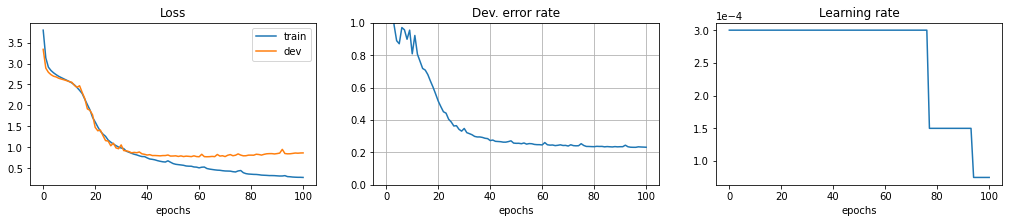

<Figure size 432x288 with 0 Axes>

In [12]:
plotLearning("config/default/history.csv")

In [13]:
from torch.autograd import Variable
import torch.utils.data

batch_size = cfg['train']['batch_size']
input_dim = 28 * 28
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for step, (xs, xlens, ys) in enumerate(train_loader):
    xs = xs.to(device) 
    ys = ys.to(device)
    #inputs = Variable(data.resize_(batch_size, input_dim))

modeled_data = model(xs, xlens, ys) #model(inputs)
print("modeled_data (loss) = ", modeled_data)
print("xs = ", xs)
print("ys = ", ys)
#model_data = modeled_data[0].reshape(batch_size, input_dim)
#print(input_data)        
#plt.imshow(model_data[0].detach().numpy().reshape(28, 28), cmap='gray')
#plt.show(block=True)

modeled_data (loss) =  tensor(0.1359, device='cuda:0', grad_fn=<NllLossBackward>)
xs =  tensor([[[-15.9424, -15.9424, -15.9424,  ..., -11.3274, -11.2768, -11.8056],
         [-15.9424, -15.9424, -15.9424,  ..., -12.0400, -12.2020, -11.1065],
         [-15.9424, -15.9424, -15.9424,  ..., -11.3163, -12.2111, -11.0919],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[-15.9424, -15.9424, -15.9424,  ..., -11.4144, -11.6839, -11.8058],
         [-15.9424, -15.9424, -15.9424,  ..., -10.3694, -10.5320, -10.3123],
         [-15.9424, -15.9424, -15.9424,  ..., -10.9855, -11.4325, -12.3224],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0

### Eval

In [14]:
# Restore checkpoint
info = torch.load("config/default/best.pth")
split = 'test'
print ("Dev. error rate of checkpoint: %.4f @epoch: %d" % (info['dev_error'], info['epoch']))
    
# Build model
tokenizer = torch.load('tokenizer.pth')
model = KalmanVAE(input_size=cfg['model']['input_size'],
            target_size=len(tokenizer.vocab),
            hidden_size=cfg['model']['hidden_size'],
            encoder_layers=cfg['model']['encoder_layers'],
            decoder_layers=cfg['model']['decoder_layers'],
            activation=cfg['model']['activation'],
            drop_p=cfg['model']['drop_p'])
 
model.load_state_dict(info['weights'])
model.eval() 
model.cuda()

# Evaluate
error = eval_utils.get_error(train_loader, model)
print ("Error rate on %s set = %.4f" % (split, error))

Dev. error rate of checkpoint: 0.2314 @epoch: 96
Calculating error rate ... (#batch: 58/58)
Error rate on test set = 0.0639


### Plot Training & Eval time

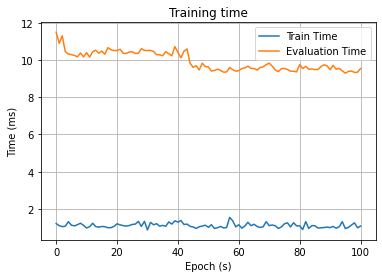

In [15]:
# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()

#now create y values for the second plot
y = train_epoch_durations
#calculate the values for the Gaussian curve
x = np.arange(len(train_epoch_durations))
#plot the Gaussian curve
ax.plot(x, y, label = "Train Time")

ax.set(xlabel='Epoch (s)', ylabel='Time (ms)',
       title='Training time')

xe = np.arange(len(eval_epoch_durations))
ye = eval_epoch_durations
#plot sine wave
ax.plot(xe, ye, label = "Evaluation Time")

ax.grid()

#show the legend
plt.legend()
plt.show()

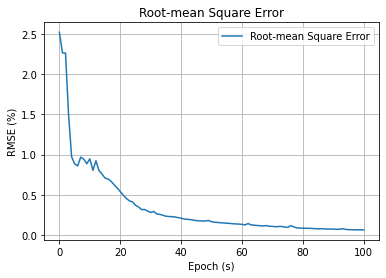

<Figure size 432x288 with 0 Axes>

In [16]:
# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()

#now create y values for the second plot
y = RMS
#calculate the values for the Gaussian curve
x = np.arange(len(RMS))
#plot the Gaussian curve
ax.plot(x, y, label = "Root-mean Square Error")

ax.set(xlabel='Epoch (s)', ylabel='RMSE (%)',
       title='Root-mean Square Error')

ax.grid()

#show the legend
plt.legend()
plt.show()
plt.savefig('img/rmse-ekf.pdf')
plt.savefig('img/rmse-ekf.png')

#### Inference auxiliary method

In [17]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import argparse
from matplotlib.pyplot import figure


def showAttention(predictions, attentions):
    output_words = predictions.split()
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,15))
    #figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    ax.set_yticklabels([''] + output_words)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

### Inference

Predict:
n ih kcl k l eh kcl m iy n s pcl p ih r ix tcl ch el pcl p er ae l ax s ix s q ao r dcl d eh th h#
Ground-truth:
h# n ih gcl g l eh kcl m iy n s pcl p ih r ix tcl ch el pcl p er ae l ax s ix s q ao r dcl d eh th h#



/home/jay/.conda/envs/jay/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


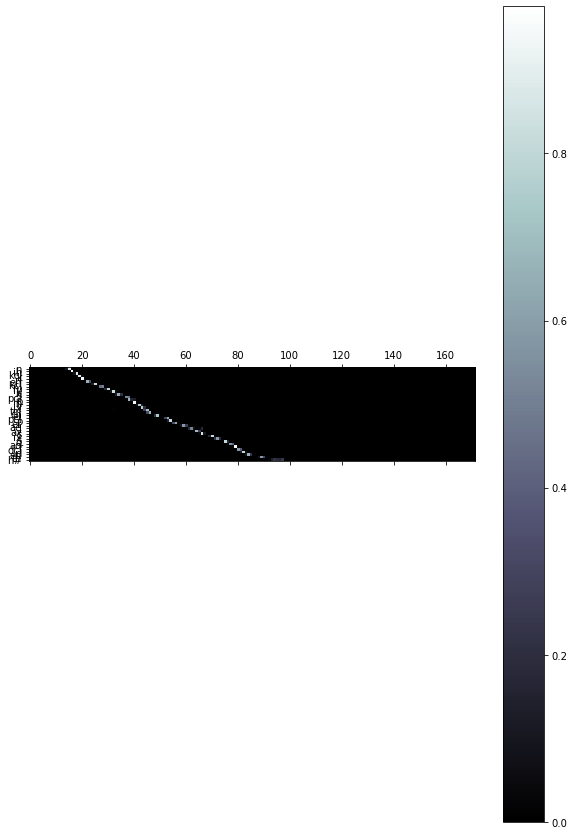

Predict:
ey bcl b ae dx axr r iy pcl p aw axr dcl r ey dx iy ow q ix z iy s eh n tcl ch el h#
Ground-truth:
h# ey bcl b ae dx axr r iy pcl p aw axr dcl r ey dx iy ow q ix z iy s eh n tcl ch el h#



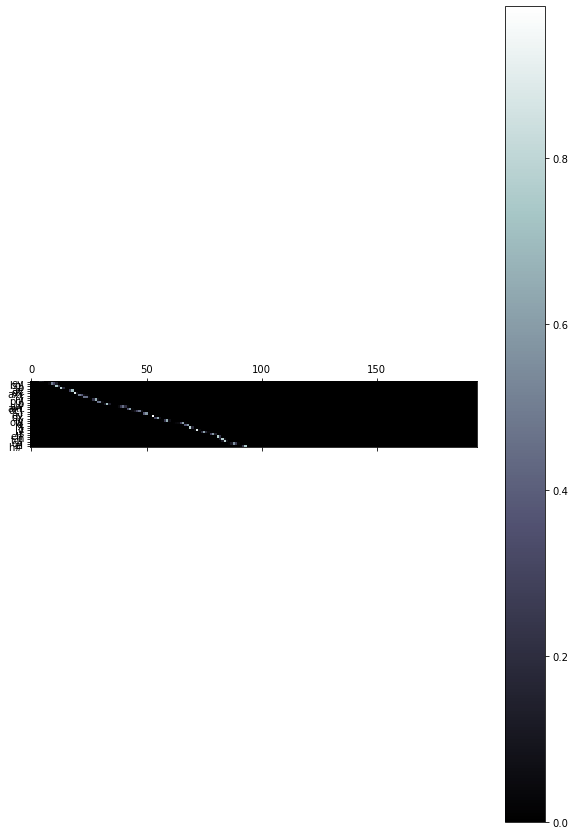

Predict:
g r eh gcl er ix n tcl t aa m tcl ch ow z tcl t ax w aa tcl ch kcl k aa r tcl t ux n z epi n iy eh f tcl t axr n ux n h#
Ground-truth:
h# g r eh gcl er iy en tcl t aa m tcl ch uh z tcl t ax w aa tcl ch kcl k aa r tcl t ux n z epi n iy eh f tcl t axr n ux n h#



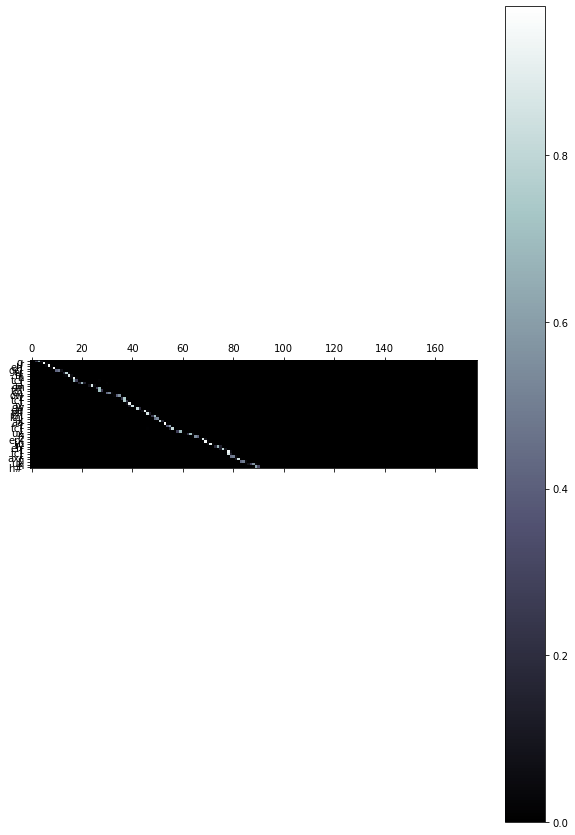

Predict:
en s tcl t eh dx ah v dh ae tcl hh iy w ix z ix ng gcl g ah l f tcl t bcl b ay bcl b eh dcl d l ax m h#
Ground-truth:
h# en s tcl t eh dx ah v dh ae tcl hh iy w ix z ix ng gcl g ah l f tcl t bcl b ay bcl b eh dcl d l ax m h#



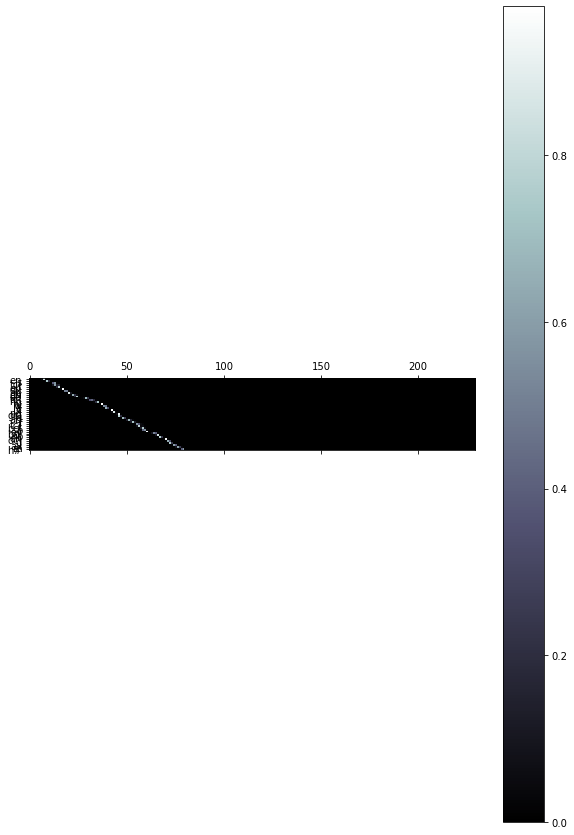

Predict:
m iy n w ay l pau th r iy gcl g r ey tcl t er ax bcl b el f ao r s ix z w er kcl k w ae gcl g y ax l ey dx ix ng ix n kcl k r ih s tcl ax l ay z ix ng h#
Ground-truth:
h# m iy n w ay l pau th r iy gcl g r ey tcl t er ax bcl b el f ao r s ix z w er kcl k ow ae gcl g y ax l ey dx ix ng ix n kcl k r ih s tcl el ay z ix ng h#



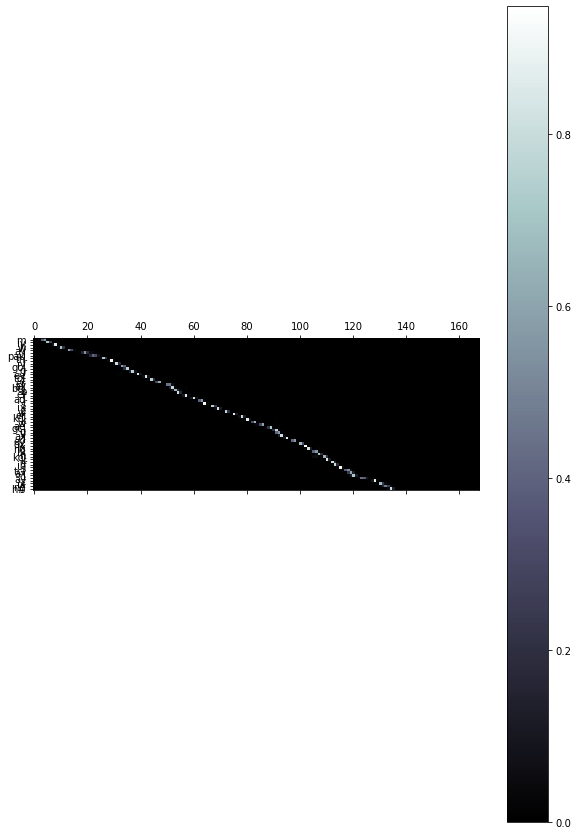

Predict:
th ih kcl g l ux q ux z dcl d ae dx ax v dh ix tcl t ux bcl h#
Ground-truth:
h# th ih kcl g l ux pau ux z dcl d aw dx ax v dh ax tcl t ux bcl h#



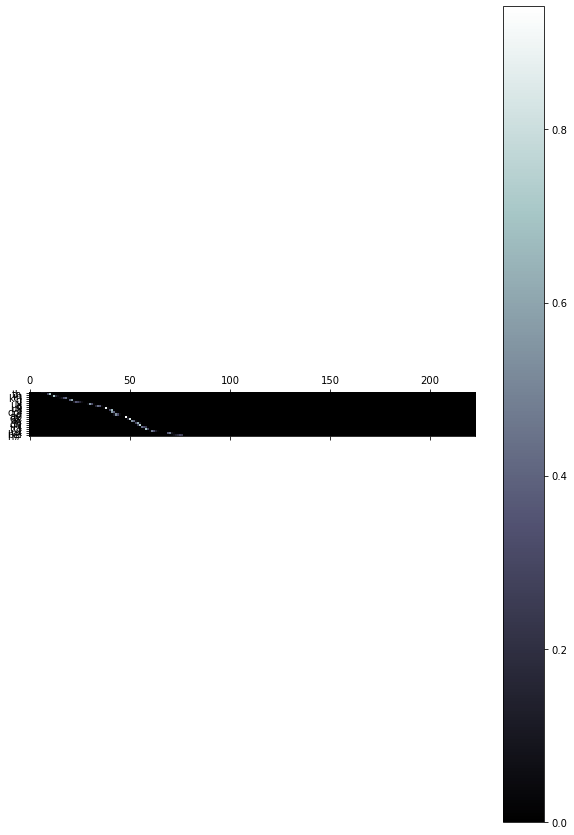

Predict:
r aa kcl k ix n r ow l m y ux z ix kcl k hh eh z ix gcl g r ey tcl r ih dh ax m h#
Ground-truth:
h# r aa kcl k en r ow l m y ux z ix kcl k hh eh z ix gcl g r ey q r ih dh ax m h#



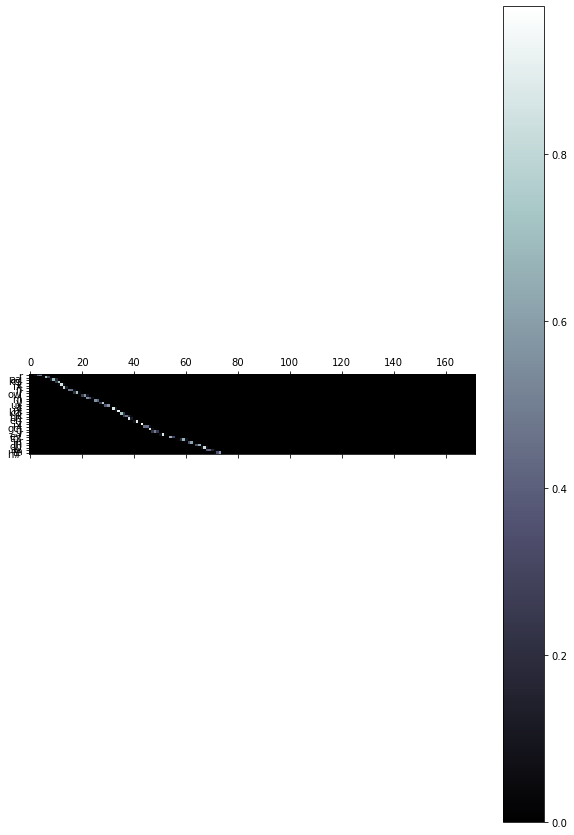

Predict:
q ax n l eh s epi w ix s eh n dcl d aw tcl dh ax hv ow l pcl p ay pau dh eh r pcl p iy s ix z m iy n ah th ix ng h#
Ground-truth:
h# ah n l eh s epi w ix s eh n dcl d aw tcl dh ax hh ow l pcl p ay pau dh eh r pcl p iy s ix z m iy n ah th ix ng h#



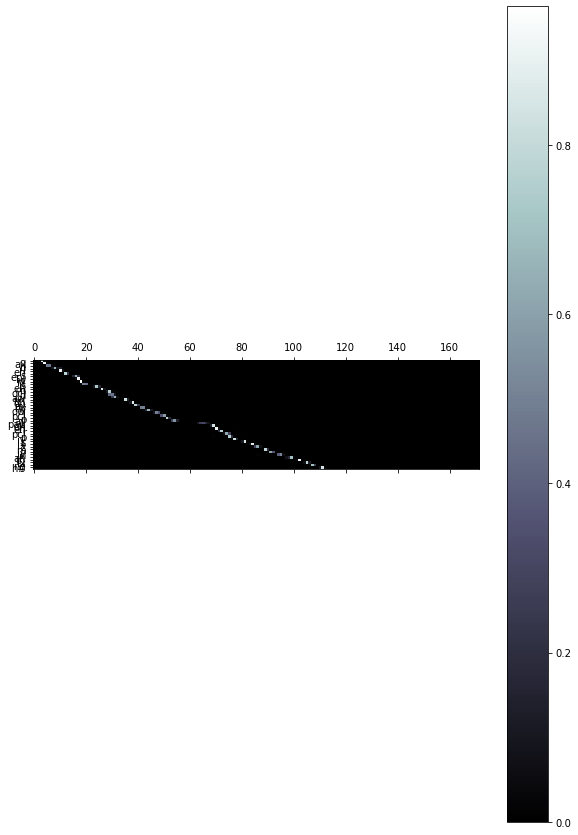

Predict:
t eh q n ih s kcl k iy bcl b iy ix v oy dx iy bcl b ay pcl p ao r ix ng w ao r m tcl t er pcl p ix n tcl t ay n q ow v er ax w ux n dcl d h#
Ground-truth:
h# t eh q n ih s kcl k ih dcl b iy ah v oy dx ih dcl b ay pcl p ao r ix ng w ao r m tcl t er pcl p ix n tcl t ay n q ow v er ax w ux n dcl d h#



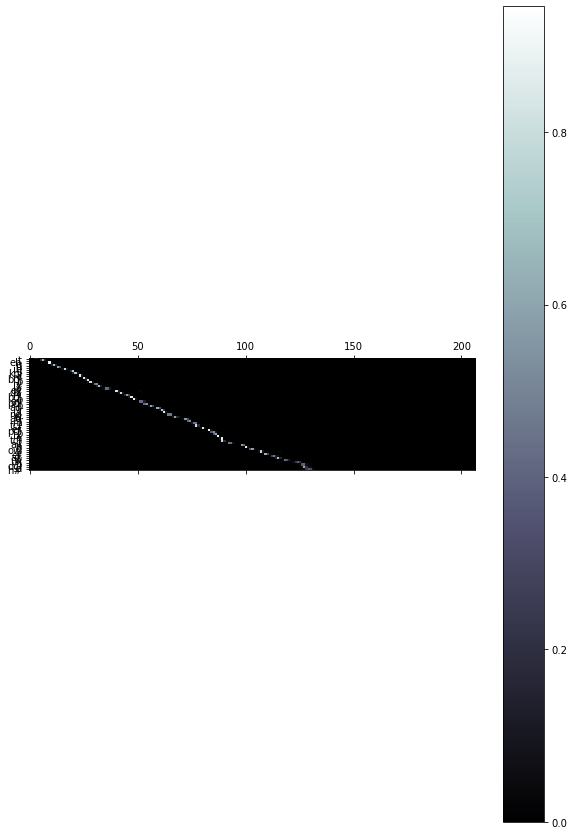

Predict:
dh ey dx ix s epi m aa dx el s er v hv aa q m iy l z ix q r iy z en bcl b el pcl p r ay s epi ix z pau ix n eh dx axr pcl p r aa f ix tcl t ax-h y ux h#
Ground-truth:
h# l ey dx ix s epi m aa dx el s er v hv aa q m iy l z ix q r iy z en bcl b el pcl p r ay s epi ix z pau ix n eh dx axr pcl p r aa f ix tcl t ax-h y ux h#



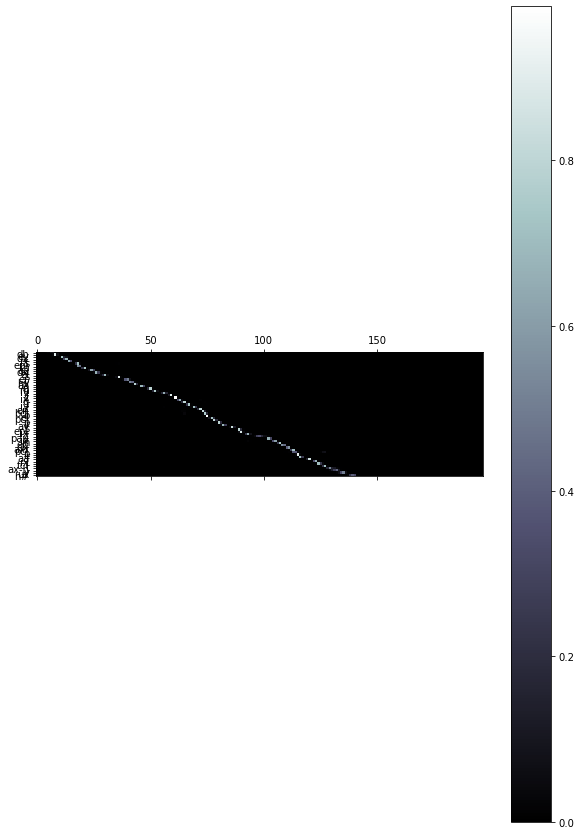

Predict:
dh iy ow l dcl d w ah m ix n q ax r ow s tcl t ih f l iy q ix n l eh dcl en iy tcl t uw ax kcl k l ih r iy ng pau w eh axr s epi m ao l hh ah tcl t s tcl t ux dcl h#
Ground-truth:
h# dh iy ow l dcl d w uh m ix n q ax r ow s tcl t ix f l iy q ax n l eh dcl d m iy tcl t uw ax kcl k l ih axr iy ng pau w eh axr s epi m ao l hh ah tcl t s tcl t ux dcl h#



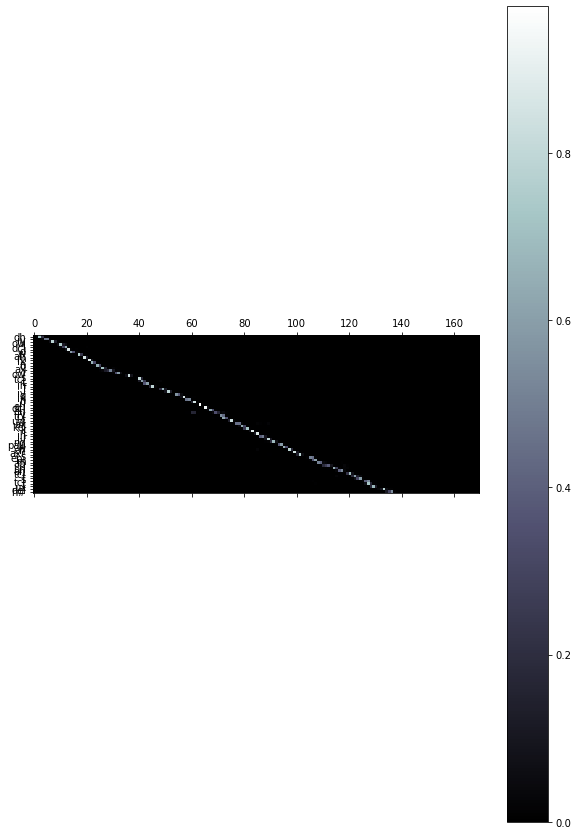

Predict:
dh ax l ow kcl k el dcl d r ah gcl g s tcl t ao r w ix z tcl ch aa r zh w ix dh ax l iy gcl g el iy dcl d ih s pcl p eh n tcl s iy n tcl t w ae ng kcl k w ax l ay z axr z h#
Ground-truth:
h# dh ax l ow kcl k el dcl d r ah gcl g s tcl t ao r w ix z tcl ch aa r zh w ix dh ax l iy gcl g ax l iy dcl d ix s pcl p eh n tcl s iy n tcl t w ae ng kcl k w ax l ay z axr z h#



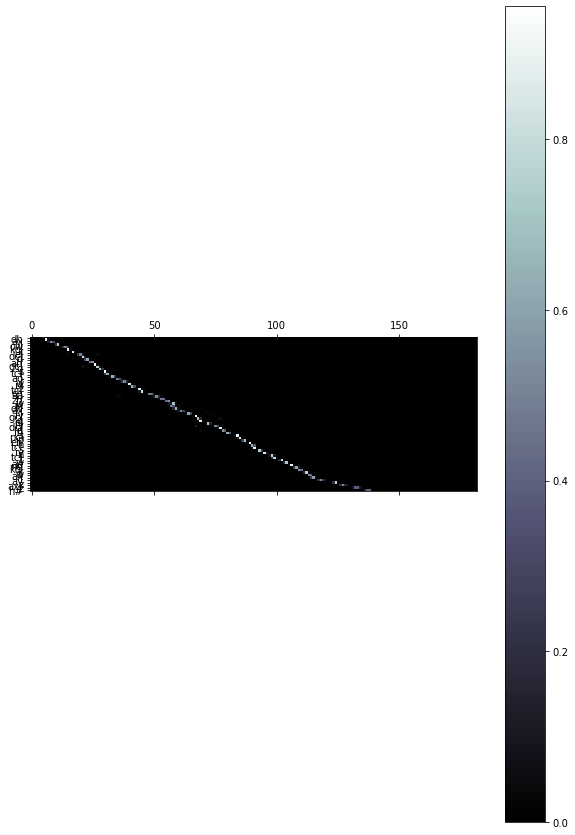

Predict:
g r ow ih ng w eh l kcl k eh pcl t gcl g aa r dcl en z ix z v eh r iy tcl t ay m kcl k en s uw m ix ng h#
Ground-truth:
h# g r ow ih ng w eh l kcl k eh pcl t gcl g aa r dcl en z ix z v eh r iy tcl t ay m kcl k en t s uw m ix ng h#



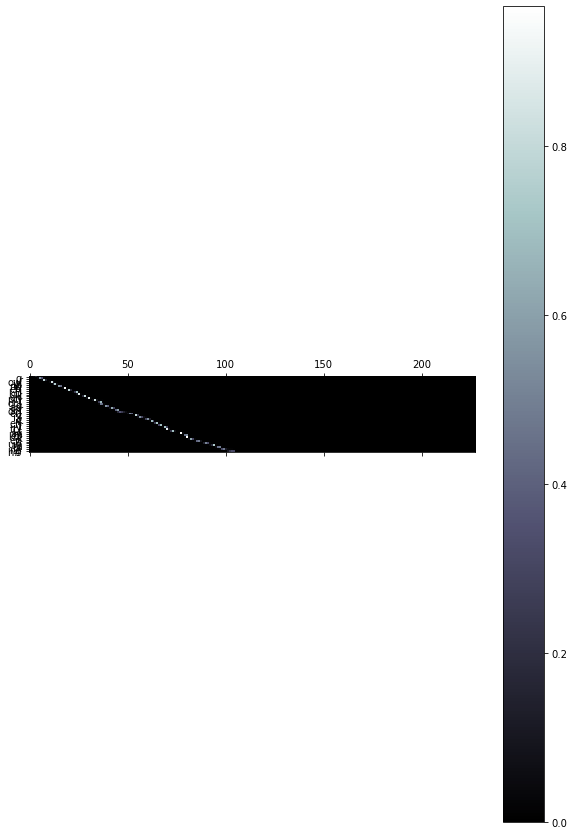

Predict:
dh ix dcl d ay gcl n ow s ix s epi w ah z dcl d ix s kcl k er ix dcl jh ix ng pau hh aw eh v axr pau hh iy w ax z n aa dx ow v axr l iy w er iy dcl d h#
Ground-truth:
h# dh ix dcl d ay gcl n ow s ix s epi w ah z dcl d ix s kcl k er ix dcl jh ix ng pau hh aw eh v axr pau hh iy w uh z n aa dx ow v axr l iy w er ix dcl d h#



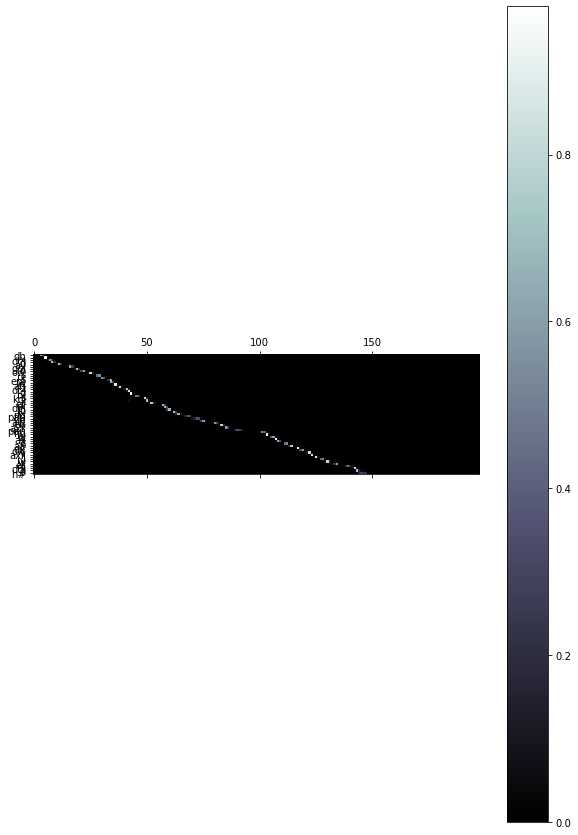

Predict:
t aa pcl p z ih n y ah z epi r eh r l iy hv ae v kcl k r uh kcl k ix dcl s tcl t eh m pcl s h#
Ground-truth:
h# t aa pcl p z ih n y ah z epi r eh r l iy hv ae v kcl k r ix kcl k ix dcl s tcl t eh m pcl z h#



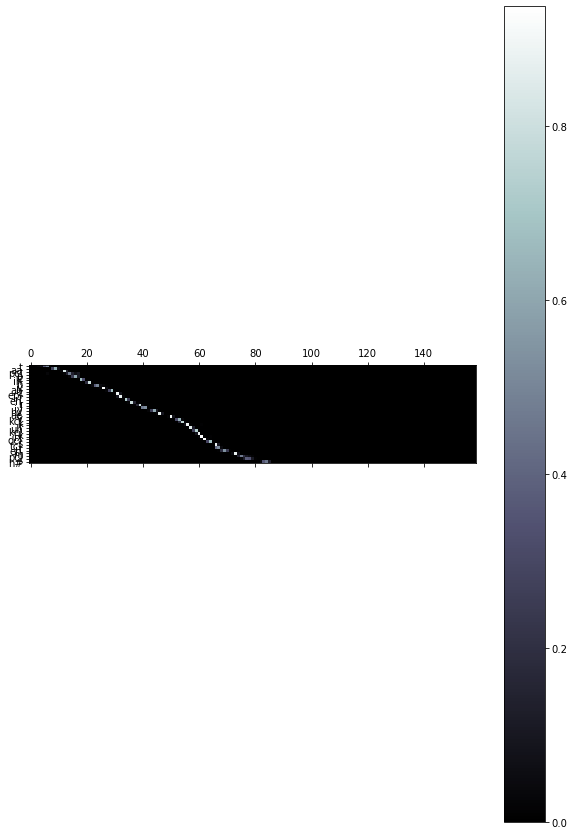

Predict:
r iy dx iy ng ih n pcl p ao ax l ay tcl t gcl g ih v z y uw q ay s tcl t r ey n h#
Ground-truth:
h# r iy dx ih ng ih n pcl p ao ax l ay tcl t gcl g ih v z y uw q ay s tcl t r ey n h#



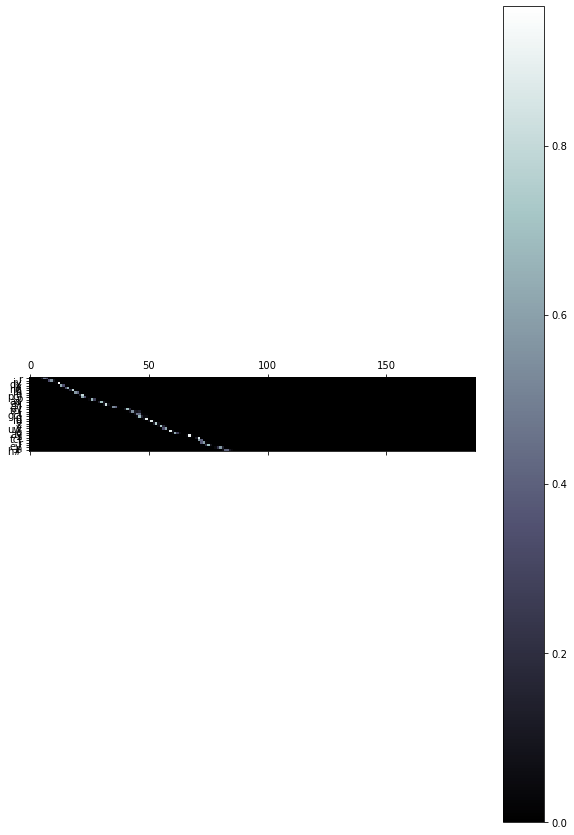

Predict:
q ae n ey th ih n dcl d ih dcl hh iy s iy dh eh m tcl t ux h#
Ground-truth:
h# q ae n ey th ih n dcl d ih dcl hh iy s iy dh eh m tcl t ux h#



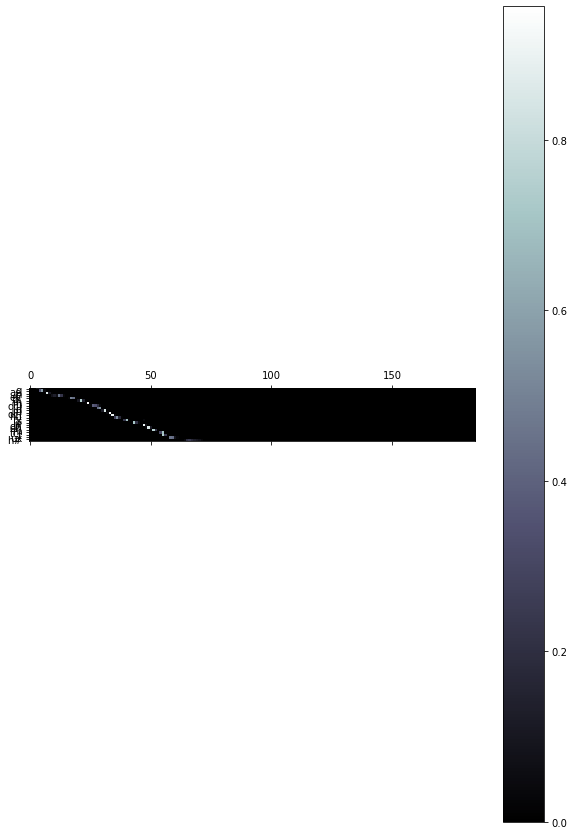

Predict:
q ax hv ux dcl jh tcl t ey pcl p ix s tcl t r iy pau hh ah ng ix n axr hv ao l w ey h#
Ground-truth:
h# q ax hv ux dcl jh tcl t ey pcl p ix s tcl t r iy pau hh ah ng ix n axr hv ao l w ey h#



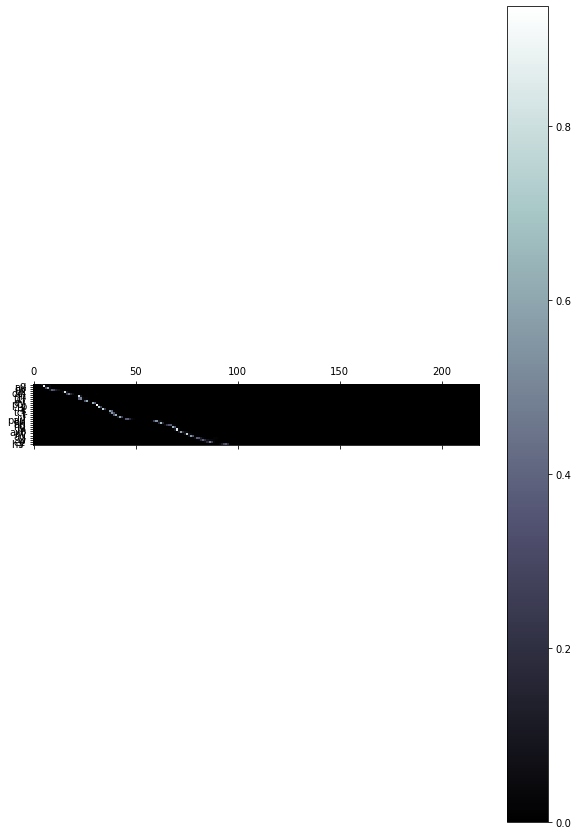

Predict:
q eh n ih th ih n ih dcl d ux w ax dh ax n ey s ax-h s pcl p ey dcl z bcl b ae dcl d l ah kcl k h#
Ground-truth:
h# q eh n ih th ih n ih dcl d ux w ax dh ax n ey s ax-h s pcl p ey dcl z bcl b ae dcl d l ah kcl k h#



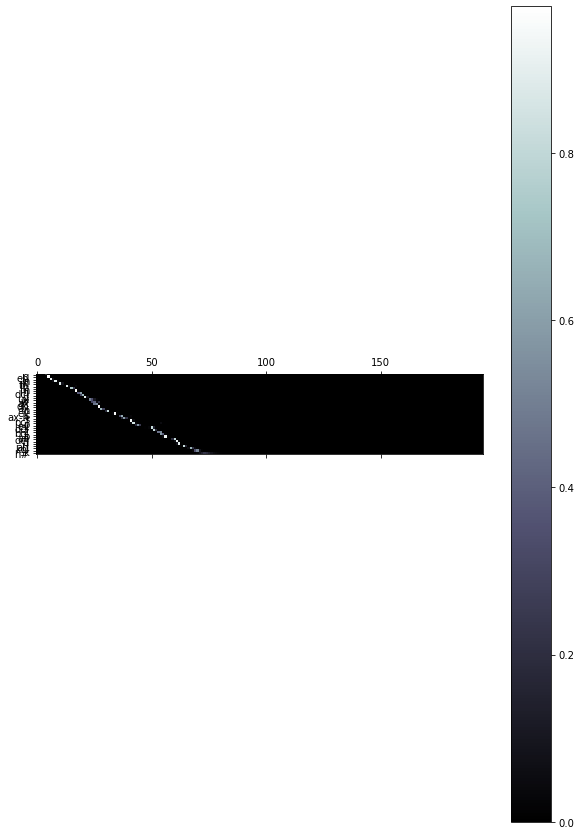

Predict:
q iy v ih n eh n pau q ih f sh ix tcl t uh kcl k w ah n s tcl t ih pcl f ow w ix dcl d hh iy kcl k ix kcl k ae tcl ch epi axr h#
Ground-truth:
h# q iy v ih n eh n q ix f sh ix tcl t uh kcl k w ah n s tcl t ih pcl f ow w ix dcl d hh iy kcl k ix kcl k ae tcl ch epi axr h#



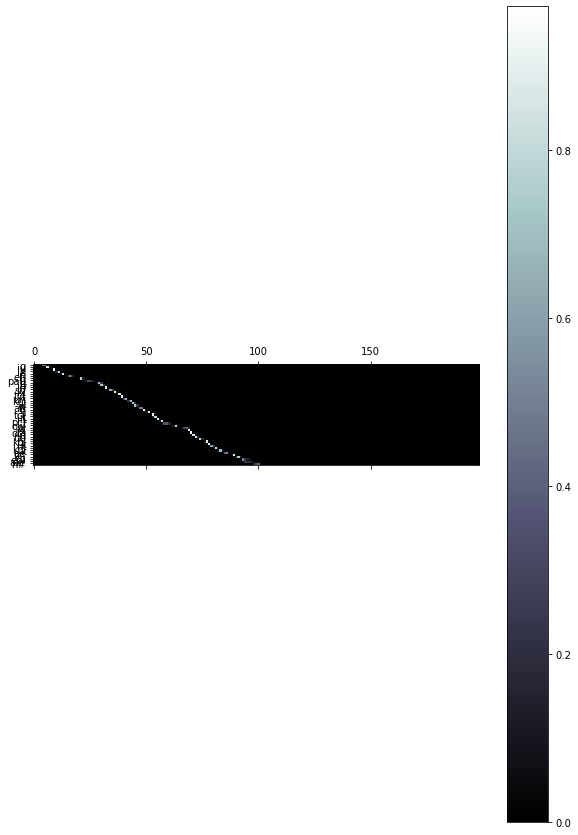

Predict:
dh ih s ix z w ah tcl n ix s eh s ix tcl t ey tcl t s dh ix n aa n s ix s tcl t ax m ae dx ix kcl k eh er kcl t er q ah v ix z dh ix s tcl t r ao nx ix m iy h#
Ground-truth:
h# dh ih s ix z w ah tcl n ix s eh s ix tcl t ey tcl s dh ix n aa n s ix s tcl t ax m ae dx ix kcl k eh er kcl t er q ah v ix s ix s tcl t r aa nx ax m iy h#



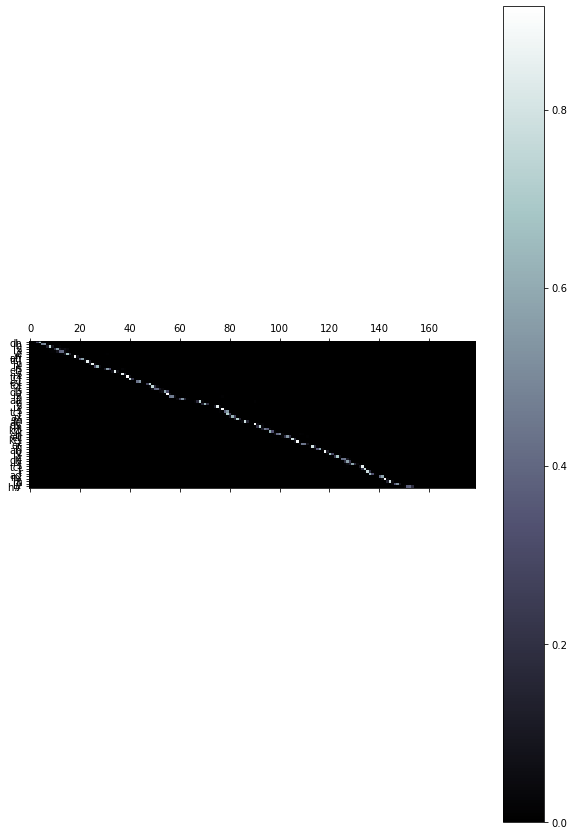

Predict:
w ix kcl k ih dcl b eh r l iy s ux dh ih f y ao r dcl d z z r ix dh ix s epi n ow f l er iy z h#
Ground-truth:
h# w ix kcl k ih dcl b eh r l iy s ux dh ih f y ao r dcl d z th r ux dh ih s epi n ow f l er iy z h#



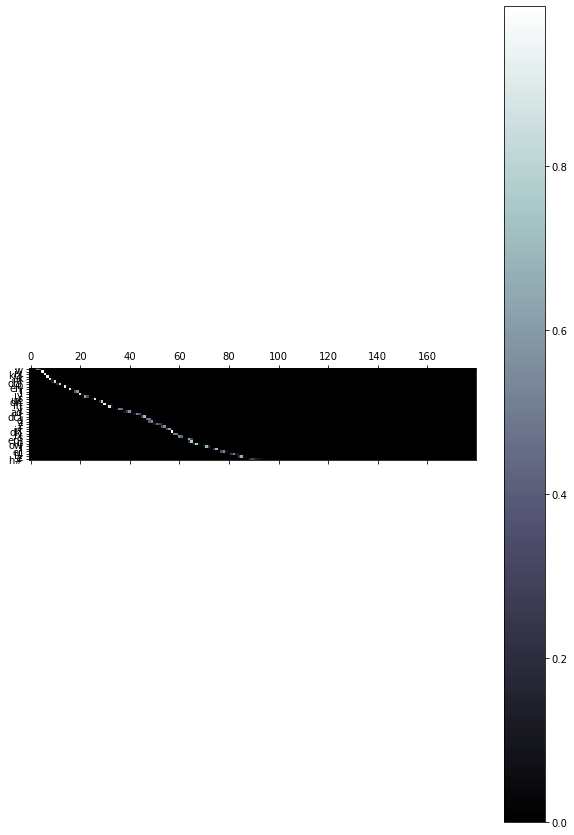

Predict:
ix s hh aa r dcl t ax tcl t eh l ax n ax r ih dcl jh ix n el pau f r ah m ax f ao r zh axr ix h#
Ground-truth:
h# ix s hh aa r dcl t ax tcl t eh l ax n ax r ih dcl jh ax n el pau f r ah m ax f ao r zh axr ix h#



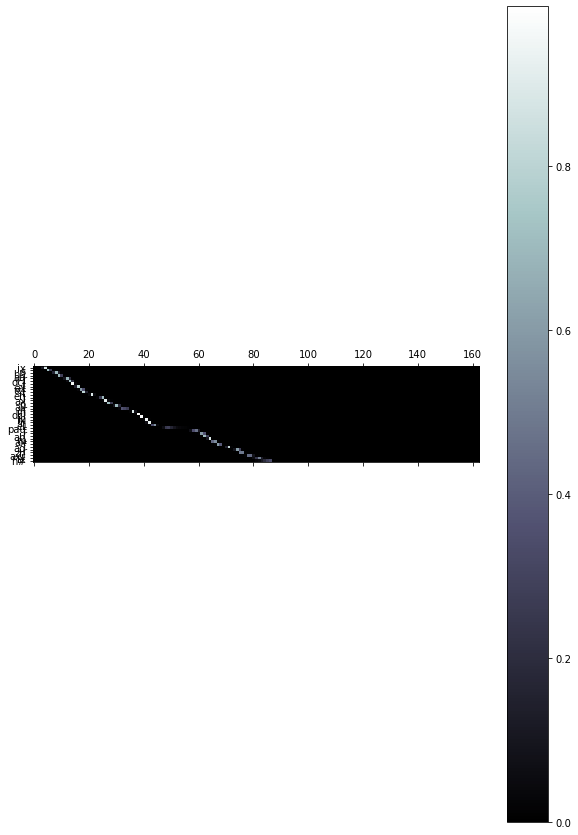

Predict:
ey kcl k r ae bcl ch ae l ax n dcl jh dcl d epi m iy pau b eh dx ix kcl k w ih kcl k s tcl t ae bcl b v ae ng kcl k w ix sh tcl t hh ih m h#
Ground-truth:
h# q ey kcl k r ae bcl ch ae l ax n dcl jh dcl d epi m iy pau b eh dx ix kcl k w ih kcl k s tcl t ae bcl b v ae ng kcl k w ix sh tcl t hh ih m h#



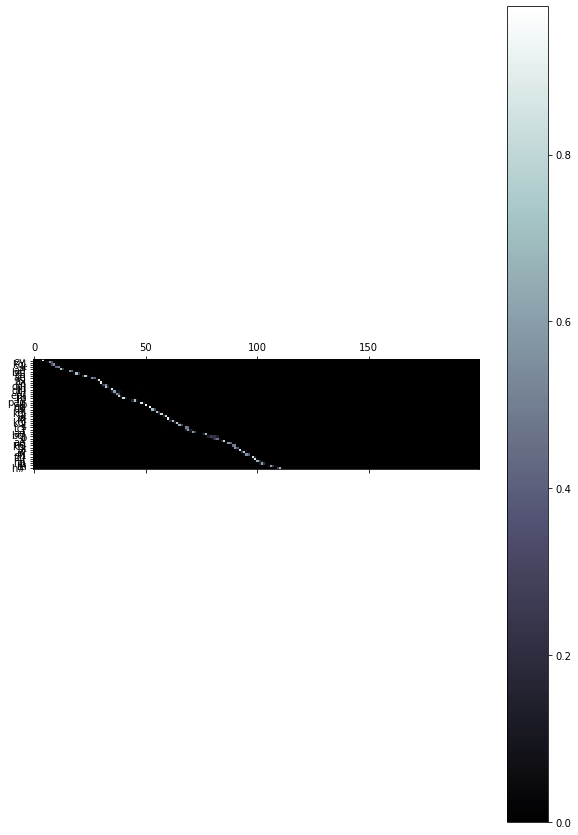

Predict:
hh ih z v oy s iy m d f ih kcl k ih n pcl p er pcl p ix s epi l ih s h#
Ground-truth:
h# hh ih z v oy s iy m d th ih kcl k ih n pcl p er pcl p ix s epi l ih s h#



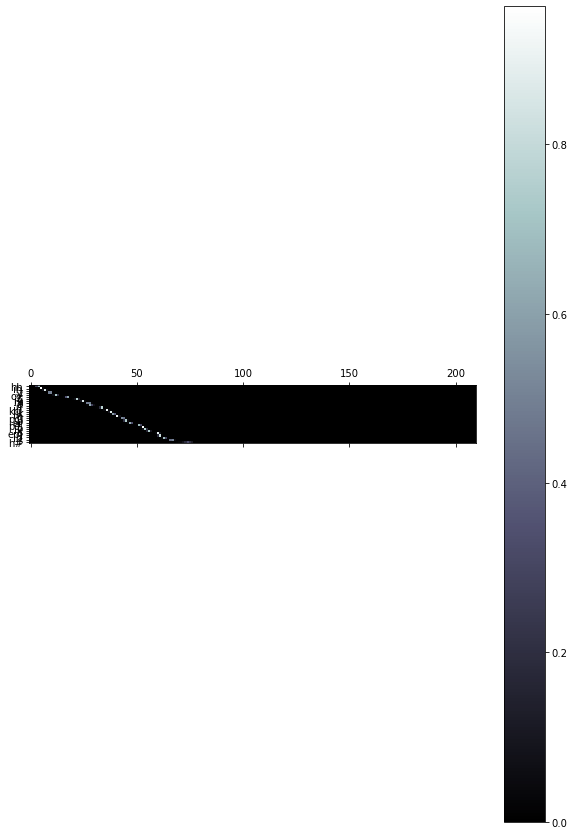

Predict:
dh eh tcl p ih kcl p aa kcl k ix tcl w ax z kcl k ao tcl r eh dcl d hv ae n dcl ix dcl h#
Ground-truth:
h# dh eh tcl p ih kcl p aa kcl k ix tcl w ax z kcl k ao tcl r eh dcl d hv ae n dcl ix dcl h#



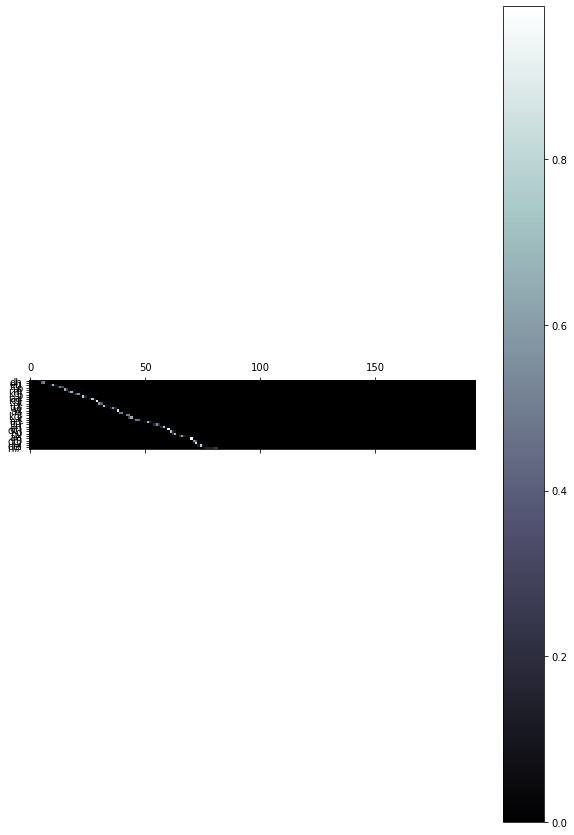

Predict:
jh ao r zh s eh l dcl d ah m w aa tcl ch ih z dcl d ey tcl t aa m ux v iy s h#
Ground-truth:
h# jh ao r zh s eh l dcl d ah m w aa tcl ch ih z dcl d ey tcl t aa m ux v iy s h#



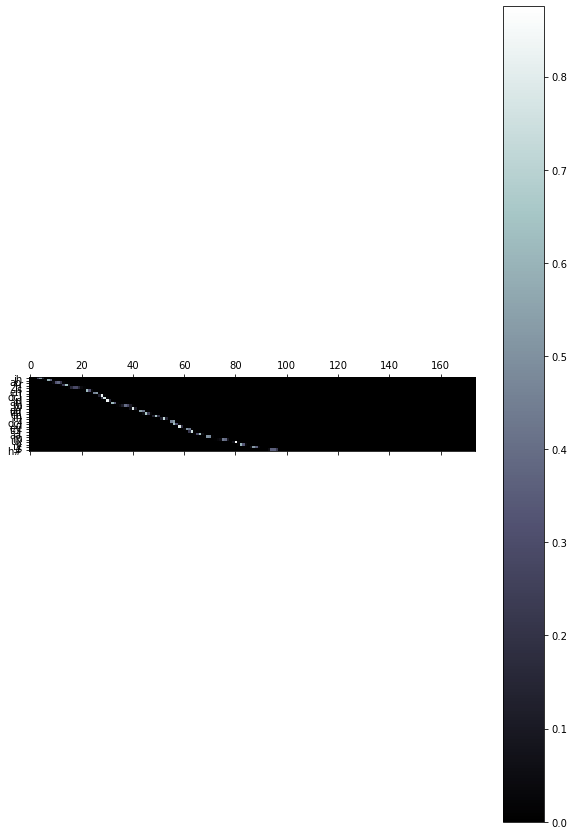

Predict:
q ow m ah dh er pau q ay s ao dh eh m h#
Ground-truth:
h# q ow m ah dh er pau q ay s ao dh eh m h#



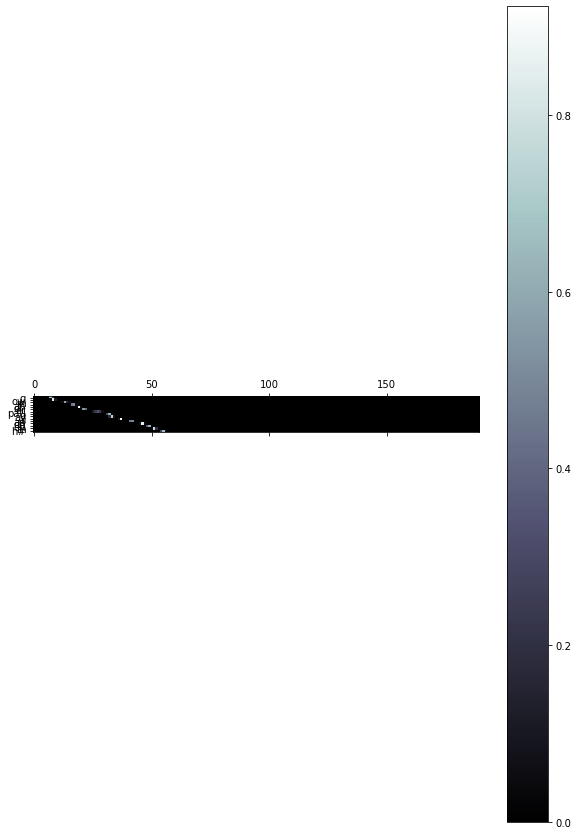

Predict:
s ao ax z bcl b r ow kcl k ix n pau s ix tcl ch aa pcl dh ax w uh dx ix n s tcl t eh dcl h#
Ground-truth:
h# s ao ah z bcl b r ow kcl k ix n pau s ix tcl ch aa pcl dh ax w uh dx ix n s tcl t eh dcl h#



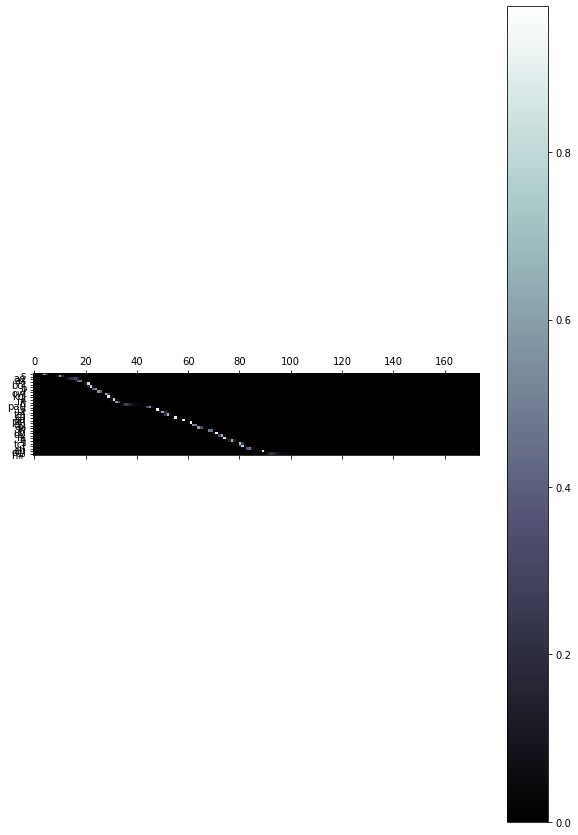

Predict:
q ay q ay dx ah m ay z q ao l ax kcl k aw n tcl s ix n m ay q ey dcl jh en tcl s iy h#
Ground-truth:
h# q ay q ay dx ah m ay z q ao l ax kcl k aw n tcl s en m ay q ey dcl jh en tcl t s iy h#



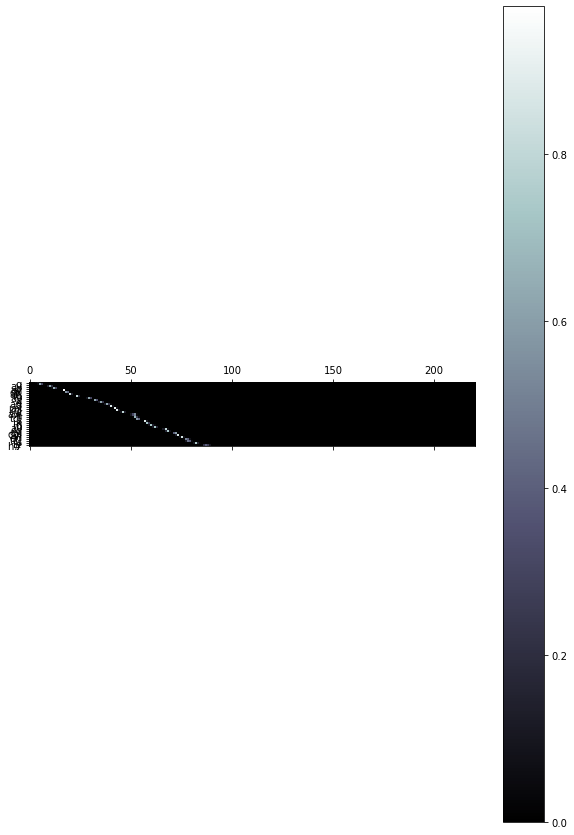

Predict:
dh ax s ih ng gcl g el kcl k er v l ay n r axr pcl p r ix z eh n tcl s ax s pcl p ax s ih f ix kcl f ao r m y ix l ey sh ix n q ix n ix tcl t eh s ix gcl g z ae m pcl p el h#
Ground-truth:
h# ax s ih ng gcl g el kcl k er v l ay n r axr pcl p r ix z eh n tcl s ax s pcl p ax s ih f ix kcl f ao r m y ax l ey sh ix n q ix n ix tcl t eh s ix gcl g z ae m pcl p el h#



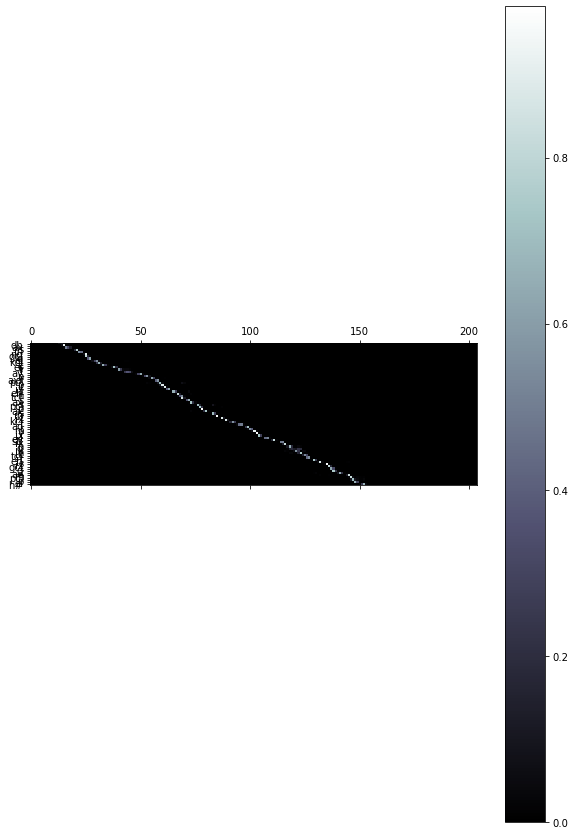

Predict:
dh ix gcl g axr r ih l ah bcl b ih v w ae kcl k r ix m ey n dcl d s ay l eh n tcl t h#
Ground-truth:
h# dh ix gcl g axr r ih l ah bcl b ih v uw w ae kcl k r iy m ey n dcl d s ay l eh n tcl t h#



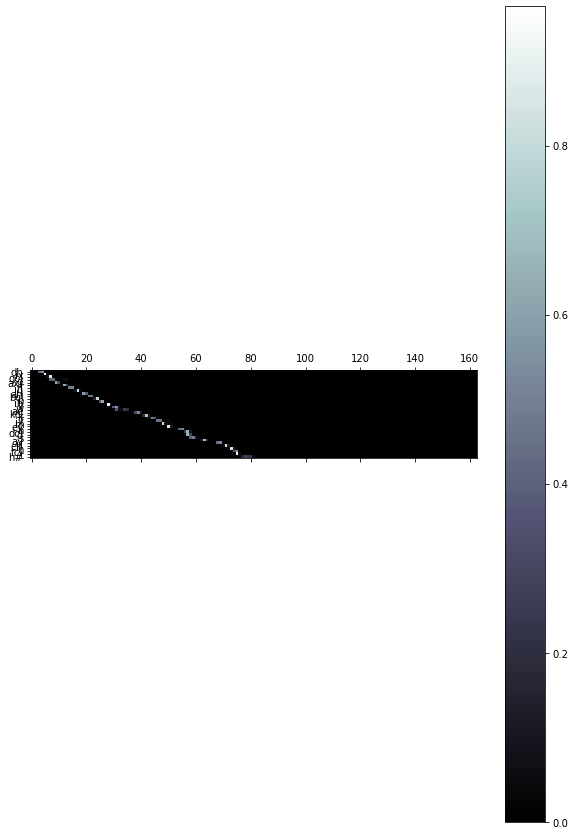

Predict:
dh ix n ux z ey zh en s iy hv ay axr dx ix gcl g r ey tcl jh er n ax l ih s tcl t h#
Ground-truth:
h# dh ax n ux z ey jh en s iy hv ay axr dx ax gcl g r ey tcl jh er n ax l ih s tcl t h#



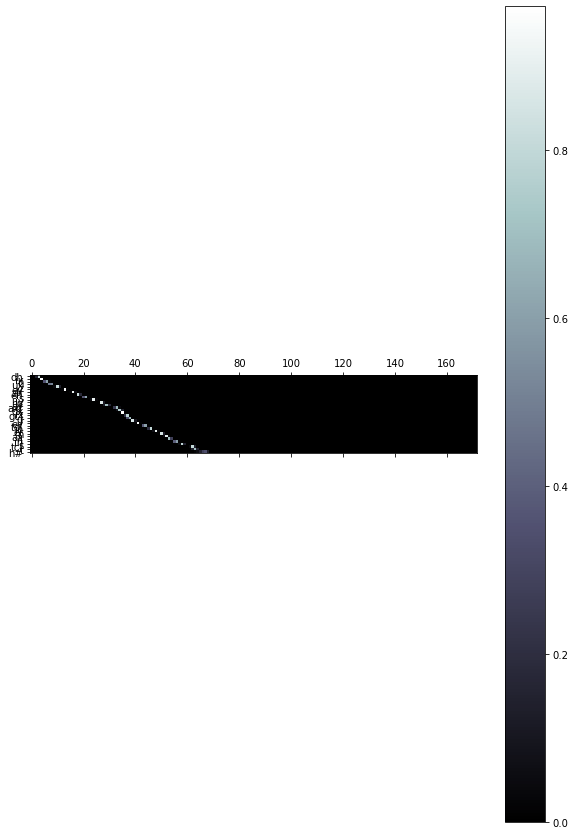

Predict:
dh eh n hv iy w uh dcl d r ih l ay z dh ey w er r ih l iy th ih ng z dh ih tcl q ow n l iy hh iy hv ih m s eh l f kcl k ix dcl th ih ng kcl k h#
Ground-truth:
h# dh eh n hv iy w uh dcl d r ih l ay z dh ey w er r ih l iy epi th ih ng z dh eh tcl q ow n l iy hh iy hv ih m s eh l f kcl k uh dcl th ih ng kcl k h#



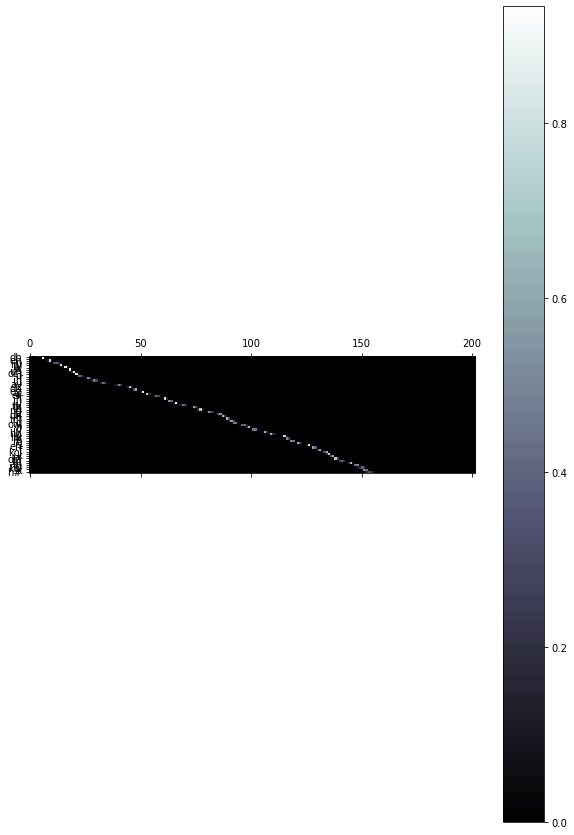

Predict:
dh ix tcl t ae kcl s iy kcl k ae bcl b r ow kcl k dcl d aw nx ix ng kcl k ao z dcl d ix tcl t r ae f ix kcl jh ae m h#
Ground-truth:
h# dh ix tcl t ae kcl s ix kcl k ae bcl b r ow kcl k dcl d aw nx ix ng kcl k ao z dcl d ix tcl t r ae f ix kcl jh ae m h#



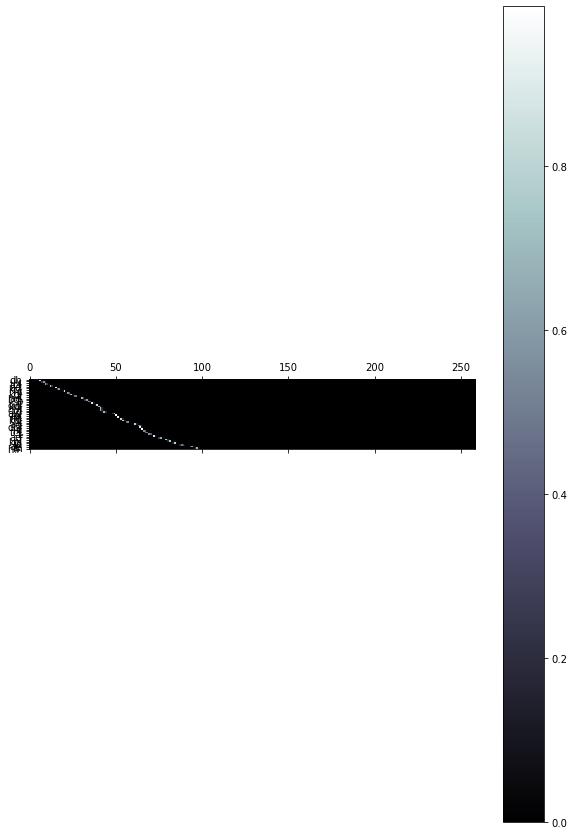

Predict:
r ey bcl iy z w er kcl k y uw r dx ao r pcl p axr v eh nx ih dcl d bcl b ay m ae dcl s tcl t ow n z w ix sh epi dh ax pcl p ay ix n iy ix w ao l axr kcl k ae r iy h#
Ground-truth:
h# r ey bcl iy z w axr kcl k y uw r dx ao r pcl p axr v eh nx ih dcl d bcl b ay m ae dcl s tcl t ow n z w ix sh epi dh ax pcl p ay ix n iy ix w ao q ao r kcl k ae r iy h#



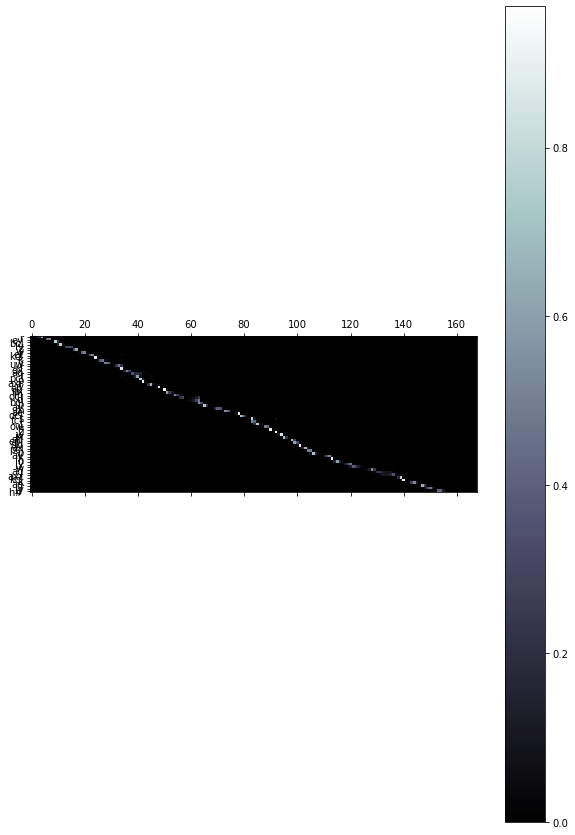

Predict:
d r ah gcl g z kcl k ih m ax kcl k el n ey m pau p r ow kcl k ey n pcl p eh nx ix s ih l ix n h#
Ground-truth:
h# d r ah gcl g z kcl k ih m ix kcl k el n ey m pau p r ow kcl k ey n pcl p eh nx ix s ih l ix n h#



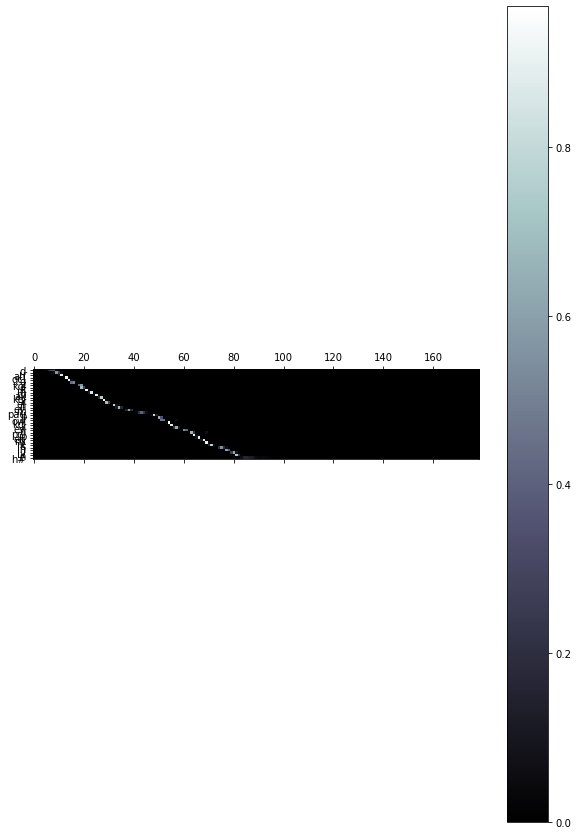

Predict:
q aw r axr s iy dcl d ix dcl jh oy nx ix pcl p oy n tcl m ax n tcl q ix n dh ix bcl b aa l ax dcl jh iy q ae n dh iy ix n dcl jh en ih r ix ng dcl d ix pcl p aa r tcl m en tcl t s h#
Ground-truth:
h# q ae l r ix s iy dcl d ix dcl jh oy nx ix pcl p oy n tcl m ax n tcl ix n dh ix bcl b aa ao l ax dcl jh iy q ae n dh iy ix n dcl jh en er ix ng dcl d ix pcl p aa r tcl m en tcl t s h#



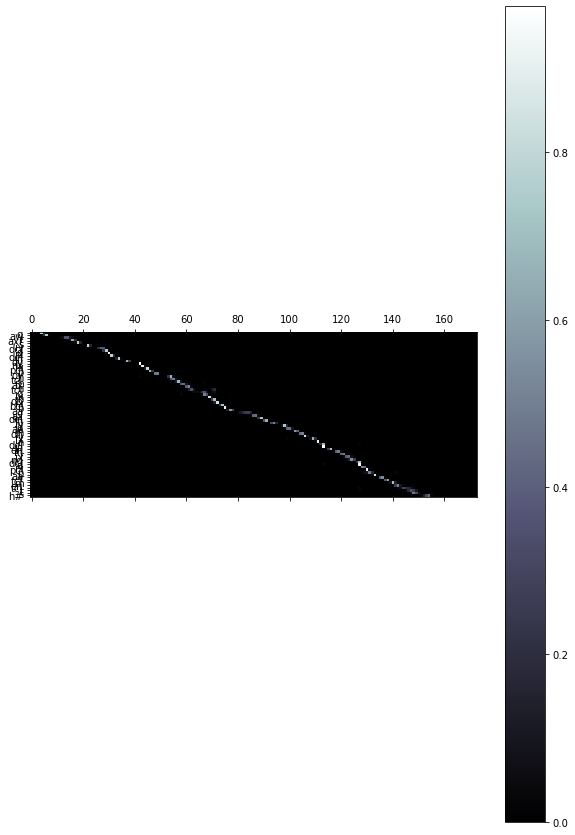

Predict:
g eh dx ey kcl k ae l ax kcl k ow kcl k ae tcl t ix kcl k iy pcl p h#
Ground-truth:
h# g eh dx ey kcl k ae l ax kcl k ow kcl k ae tcl t ix kcl k iy pcl p h#



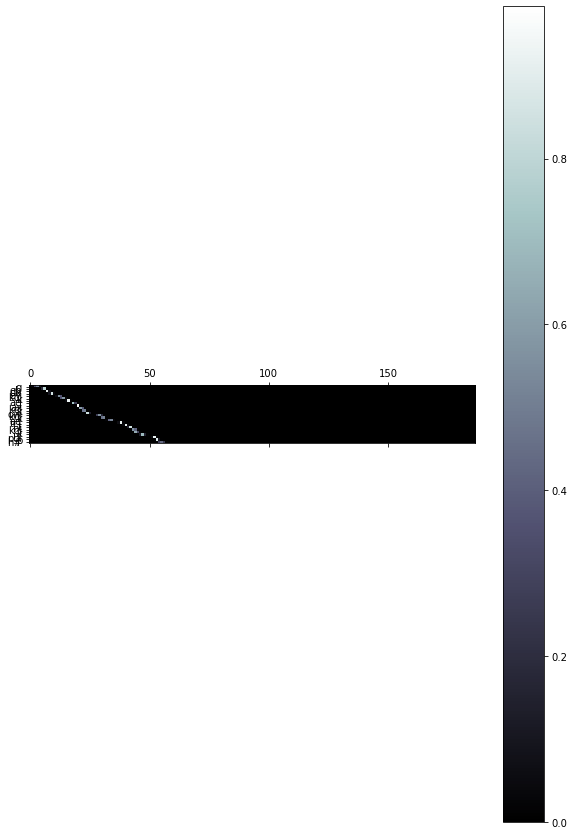

Predict:
p y er iy s ix m f r uw tcl b ax f ao r pcl p axr pcl p er ih ng dh ix s kcl k y uw axr z h#
Ground-truth:
h# p y er iy s ix m f r ux tcl b ax f ao r pcl p axr pcl p eh r ih ng dh ix s kcl k y uw axr z h#



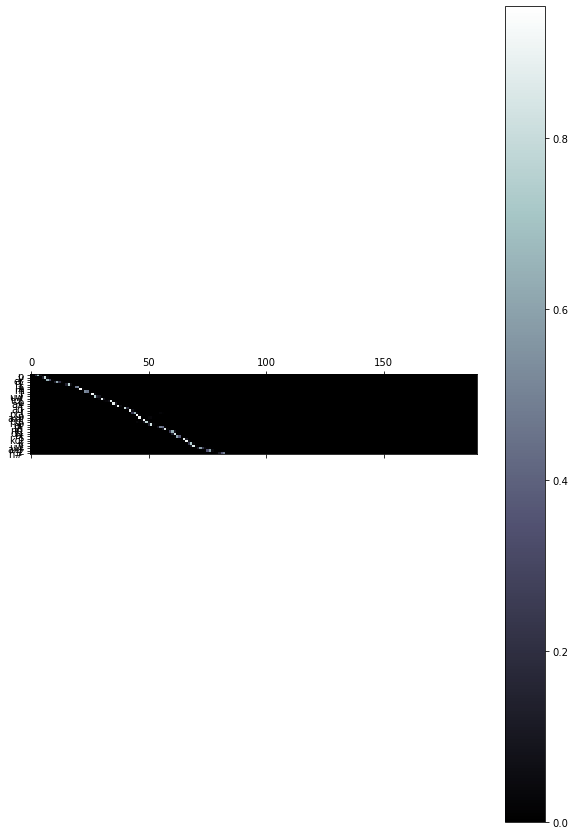

Predict:
hh w ih tcl ch l ao ng aa r dx ix kcl k el w ax z ow pcl p ey kcl k pau eh n iy dx ix dcl k l eh r axr f ix kcl k ey sh en h#
Ground-truth:
h# hh w ih tcl ch l ao ng aa r dx ix kcl k ax l w ax z ow pcl p ey kcl k pau ae n iy dx ix dcl k l eh r axr f ix kcl k ey sh en h#



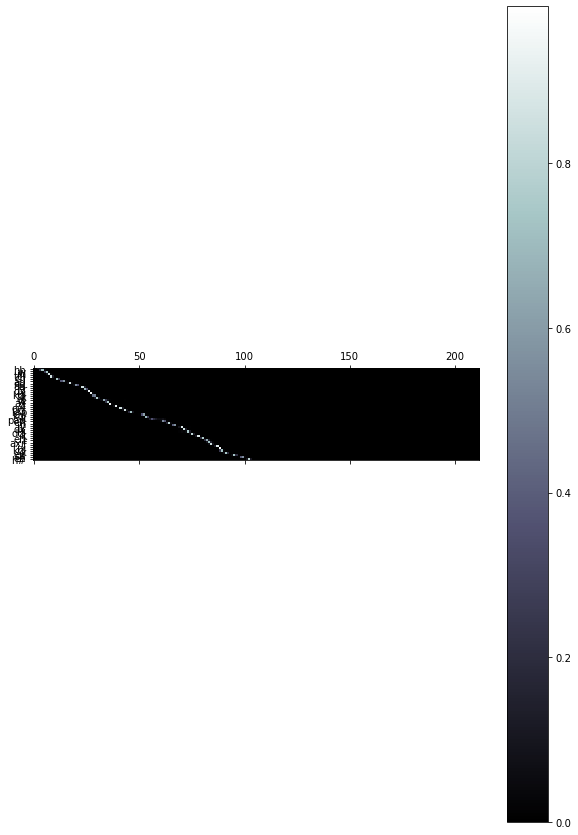

Predict:
k aw n tcl dh ix n ah m bcl b er ix v tcl t iy s pcl p uw n z ah v s ow iy s ao s dh eh tcl ch uw ae dcl h#
Ground-truth:
h# k aw n tcl dh ix n ah m bcl b er ix v tcl t iy s pcl p uw n z ah v s ow iy s ao s dh eh tcl ch uw ae dcl h#



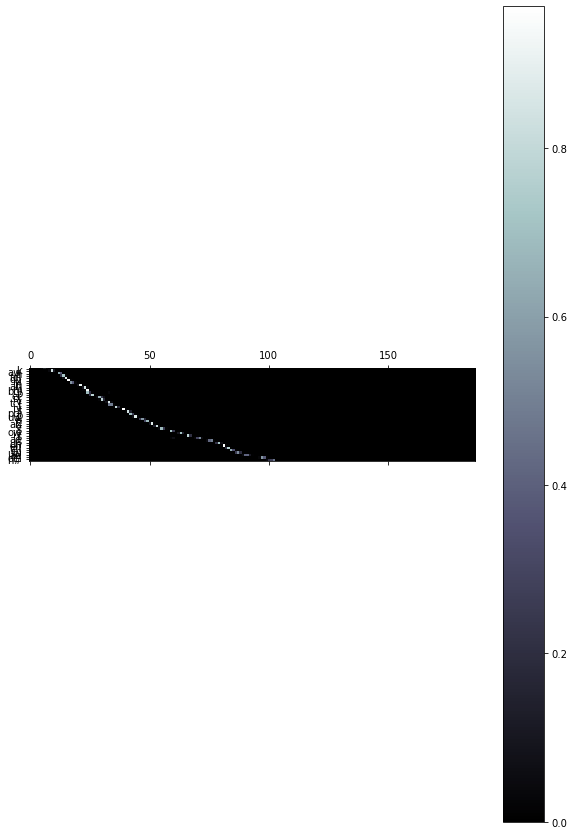

Predict:
ay l hv ae v ax s kcl k uw pcl p ax v dh ae dx ih gcl g z aa dx ix kcl p er pcl p el eh n tcl t er kcl k oy z pau sh er bcl b axr tcl h#
Ground-truth:
h# ay l hv ae v ax s kcl k uw pcl p ax v dh ae dx ix gcl g z aa dx ix kcl p er pcl p el eh n dcl t er kcl k oy z pau sh er bcl b axr tcl h#



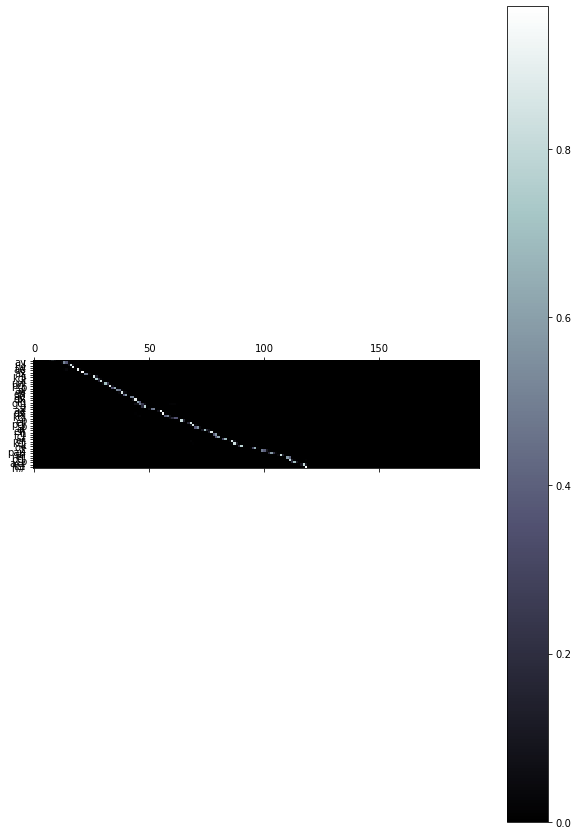

Predict:
ax kcl k aa n ax s er w el ix n dcl jh oy dh ix s sh eh l f ax sh dcl d ah sh h#
Ground-truth:
h# q ax kcl k aa n ax s er w el ix n dcl jh oy dh ix s sh eh l f ax sh dcl d ax sh h#



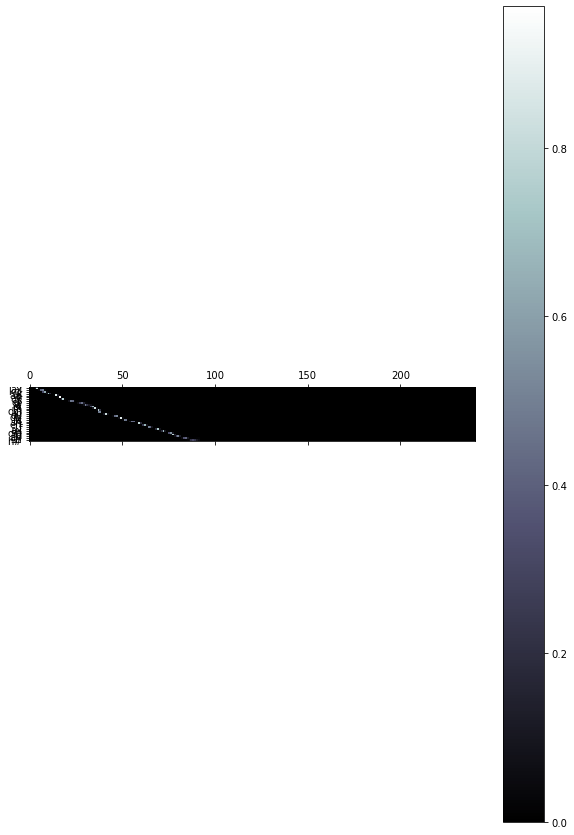

Predict:
hh eh z w iy ix bcl s er v m ao r ax l ao ix n f ih z ix kcl k el l ao dh ey ix pcl p ih axr q eh z bcl b iy ix ng ix n eh v ix dx ax bcl b el h#
Ground-truth:
h# hh ae z w iy ax bcl s er v m ao r ax l ao eh n f ih z ix kcl k el l ao dh ey ix pcl p ih axr q eh z bcl b iy ix ng ih nx eh v ix dx ax bcl b el h#



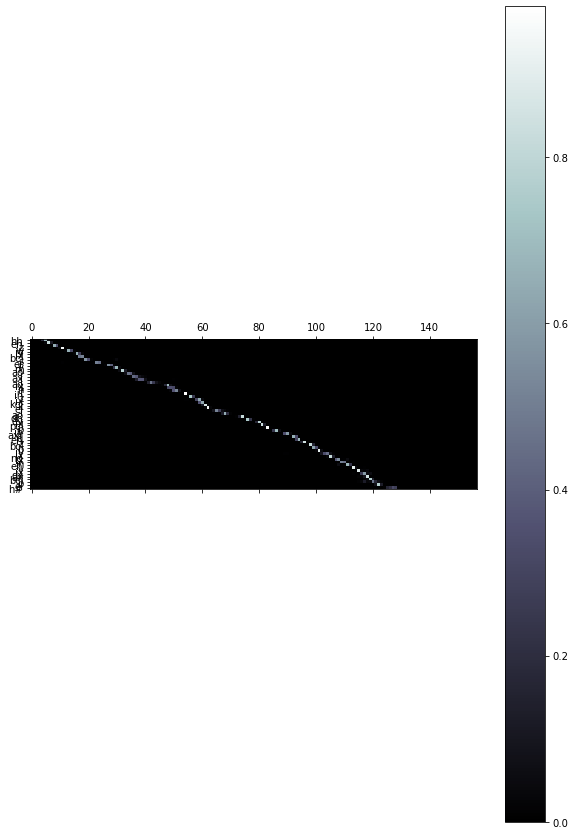

Predict:
hh ih z f ih ng gcl g er z f ah m bcl b el dx ix kcl k r ao s dh ax bcl b ae n dcl d ix dcl jh ih z h#
Ground-truth:
h# hh ih z f ih ng gcl g axr z f ah m bcl b el dx ax kcl k r ao s dh ax bcl b ae n dcl d ix dcl jh ih z h#



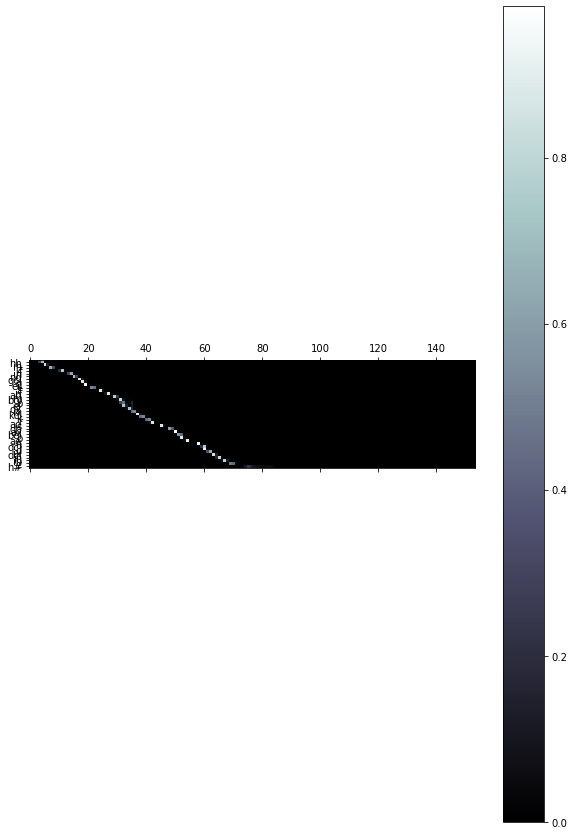

Predict:
dh iy ae dcl v axr tcl t ay z ix ng v er s ax v pcl p l ih m ih th f axr ay ix dx iy s tcl t ao r n eh v axr tcl ch ey n jh ix z h#
Ground-truth:
h# dh iy ae dcl v axr tcl t ay z ix ng v er s ax v pcl p l ih m ih th f axr ay ix dx iy s tcl t ao r n eh v axr tcl ch ey n jh ix z h#



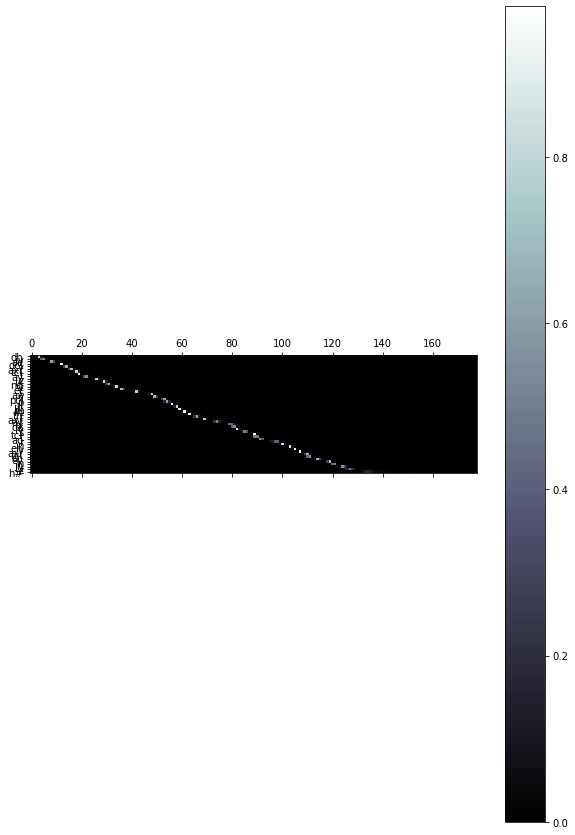

Predict:
m uw v iy z n eh v axr hv ae v ax n ah f ih l ax n z h#
Ground-truth:
h# m uw v iy z n eh v axr hv ae v ax n ah f ih l ax n z h#



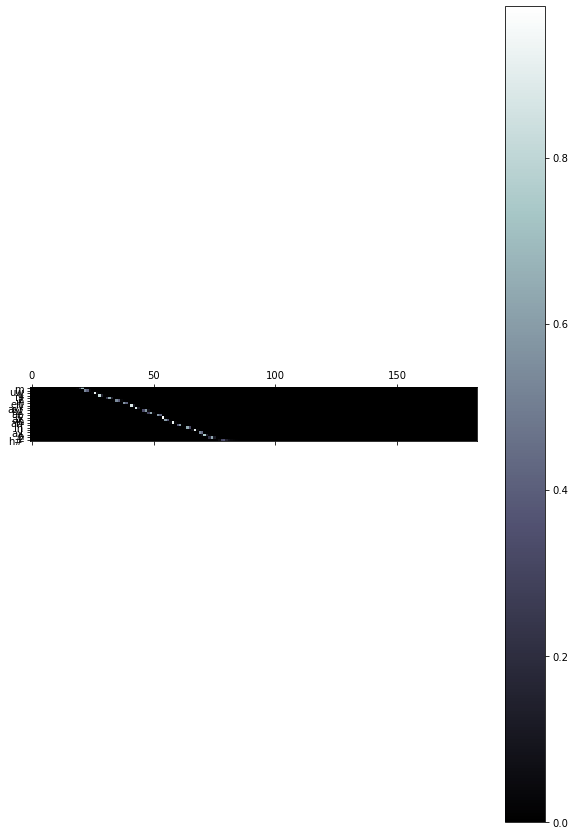

Predict:
ih n iy q ao r gcl ix n ix z ix m th eh tcl f ao l tcl t er z q ao r m ih s pcl p axr s iy z ix s ih gcl n ax l z pau ao r w iy kcl k ix n z ix z dcl d ah n h#
Ground-truth:
h# q ix n iy q ao r gcl ix n ih z ax m epi dh eh tcl f aa l tcl t er z q ao r m ih s pcl p axr s iy z ix s ih gcl n ax l z pau er w iy kcl k ix n z ix z dcl d ah n h#



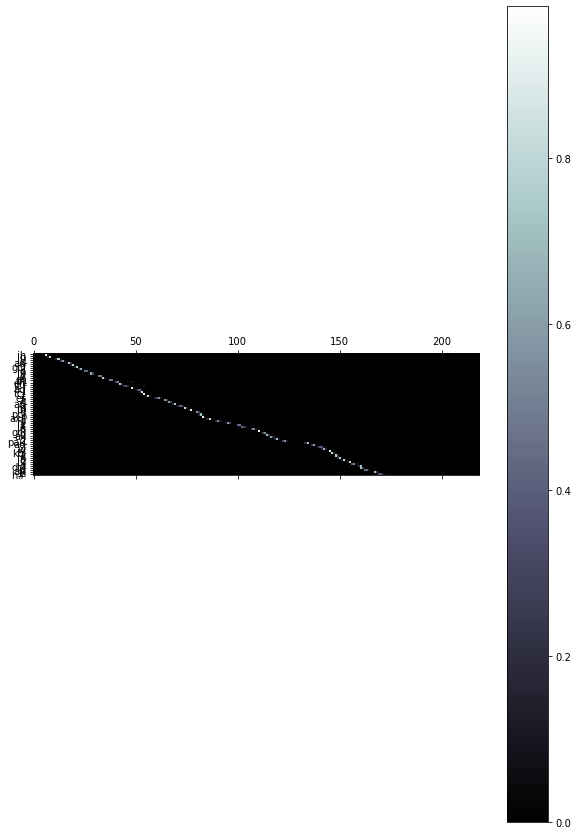

Predict:
hh iy hv ux dcl d ih z n aa q l ah v q ax bcl b ay dcl z q ih n dcl d eh th h#
Ground-truth:
h# hh iy hv ux dcl d uh z n aa q l ah v q ax bcl b ay dcl z q ih n dcl d eh th h#



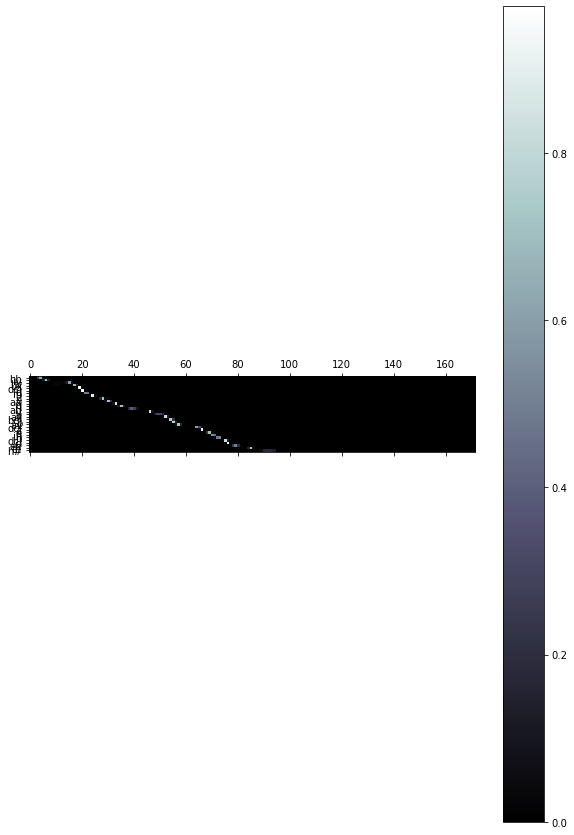

Predict:
n ow m ey n y ix f ae kcl sh er ax n z tcl t ey kcl k ix nx iy ix n ih sh en tcl t ih v ix n pcl p oy n tcl t iy ae l dh ix kcl k ao s tcl ix n v ao l v dcl d h#
Ground-truth:
h# n ow m eh n y ix f ae kcl sh er ax hv z tcl t ey kcl k ix nx iy ix n ih sh ax-h tcl t ih v ix n pcl p oy n tcl t iy aw tcl dh ix kcl k ao s tcl ix n v ao l v dcl d h#



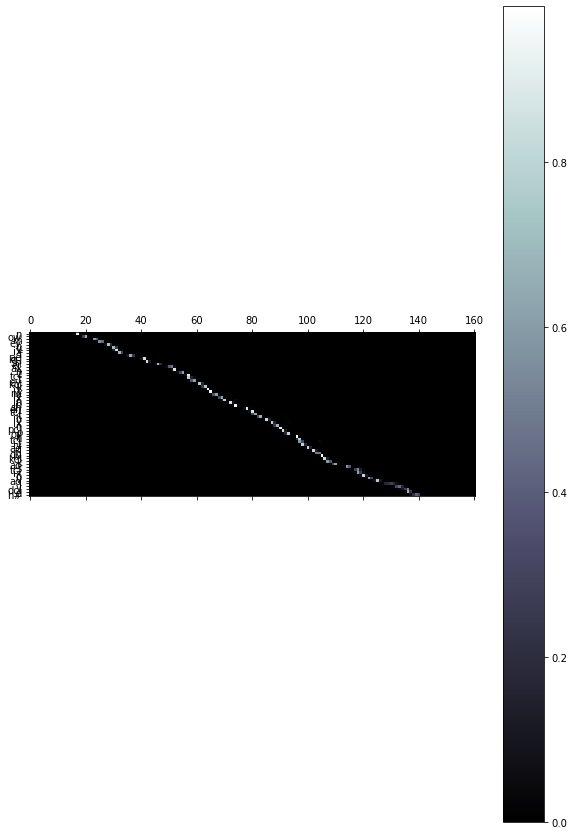

Predict:
dh ix dcl jh ay eh n tcl r eh dcl w uh dcl d sh ih m er dcl d ih n dh ix gcl g l ih s epi n ih ng s ah n h#
Ground-truth:
h# dh ix dcl jh ay ih n tcl r eh dcl w uh dcl d sh ih m er dcl d ih n dh ix gcl g l ih s epi n ih ng s ah n h#



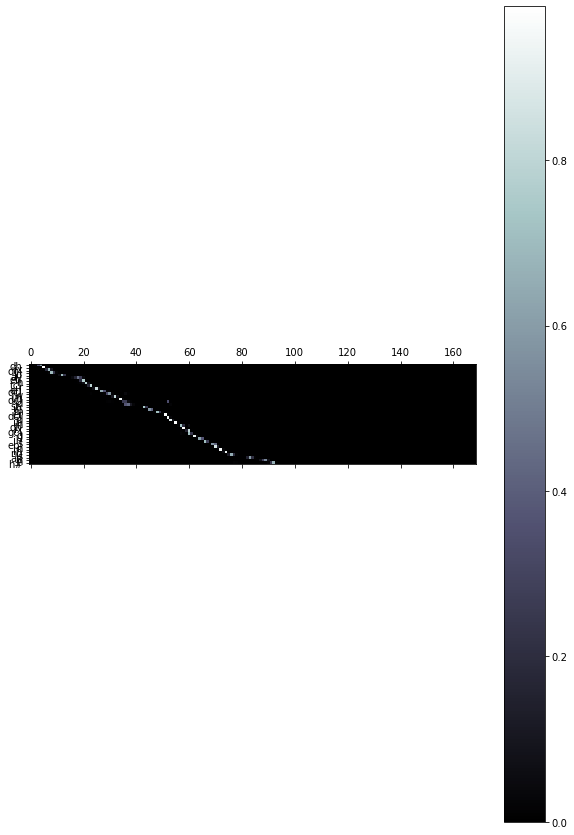

Predict:
eh n ih dcl d ah l tcl m ey l bcl b ae bcl b ux n z tcl t iy th q aa r n aa q s ux dx ix bcl b el f axr q iy dx ix ng sh eh l f ih sh h#
Ground-truth:
h# eh n ih dcl d ah l tcl m ey l bcl b ae bcl b uw n z tcl t iy th q aa r n aa q s ux dx ix bcl b el f axr q iy dx ix ng sh eh l f ih sh h#



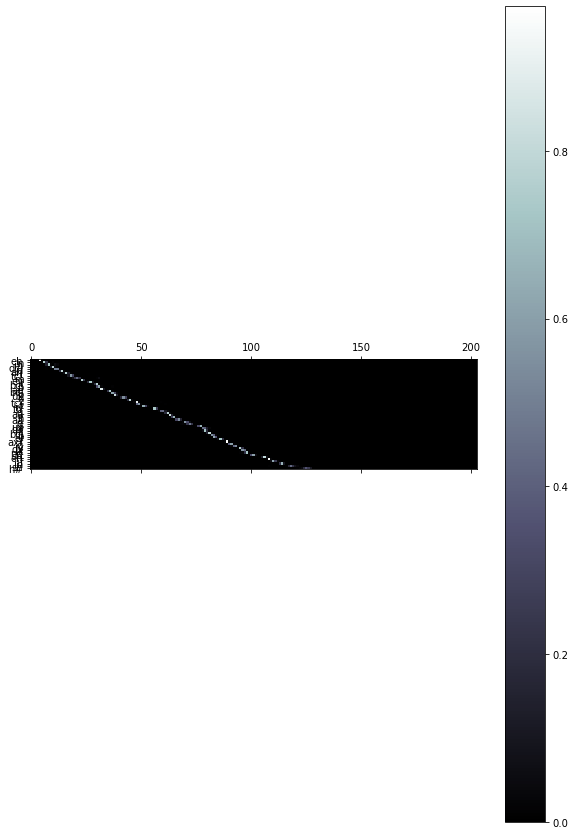

Predict:
ih s ix m pcl p aa s ax bcl b el tcl t ux dcl d iy l w ix th bcl b ih r aa kcl k axr s iy h#
Ground-truth:
h# q ih s ix m pcl p aa s ax bcl b el tcl t ux dcl d iy ax l w ix th bcl b ih r aa kcl k axr s ix h#



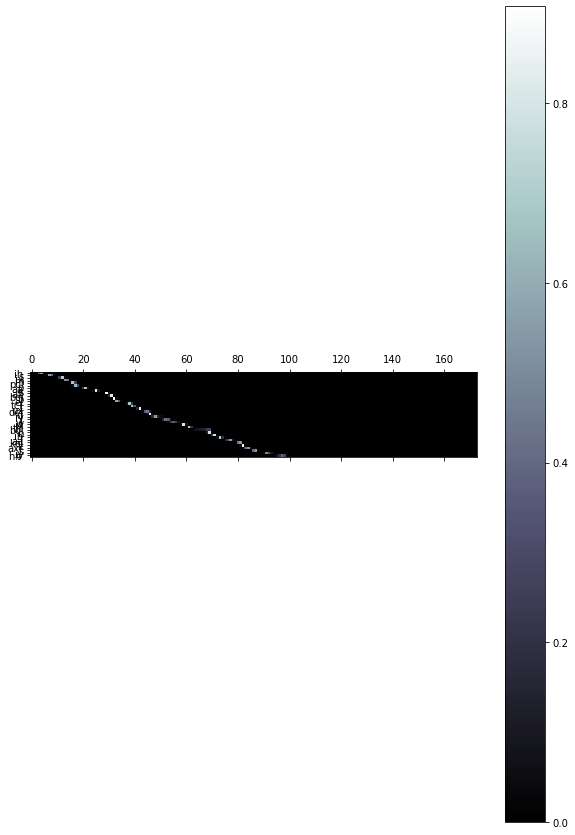

Predict:
dh axr gcl g ey tcl ix z em pcl p aa s epi w el dcl d ax kcl k en v ey ix n w er dcl d z h#
Ground-truth:
h# dh axr gcl g ey tcl ix z em pcl p aa s ax-h bcl b el dcl d ax kcl k en v ey ix n w er dcl d z h#



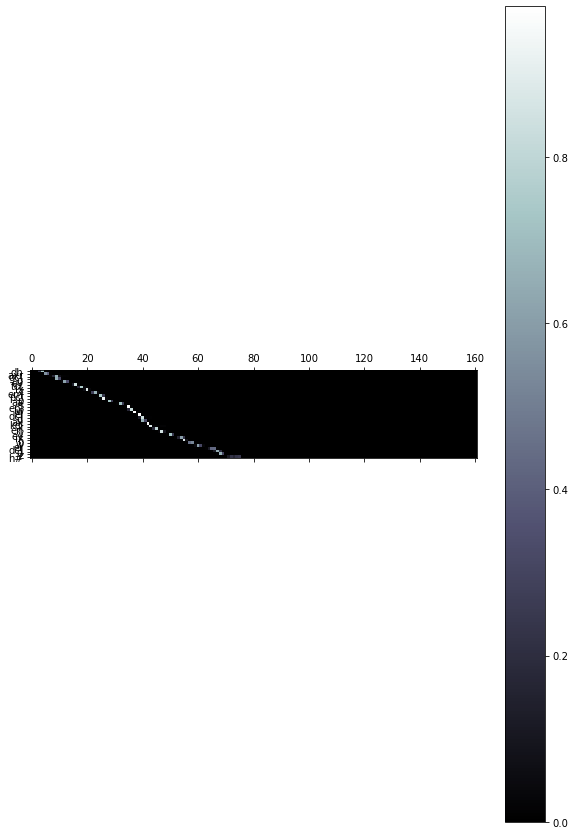

Predict:
m ey ay q ao r dx er ah s tcl t r ao v er iy s ah n dcl d ey q ae f tcl t axr ay iy tcl d ih n axr h#
Ground-truth:
h# m ey ay q ao r dx er ah s tcl t r ao v axr iy s ah n dcl d ey q ae f tcl t er ay iy tcl d ih n axr h#



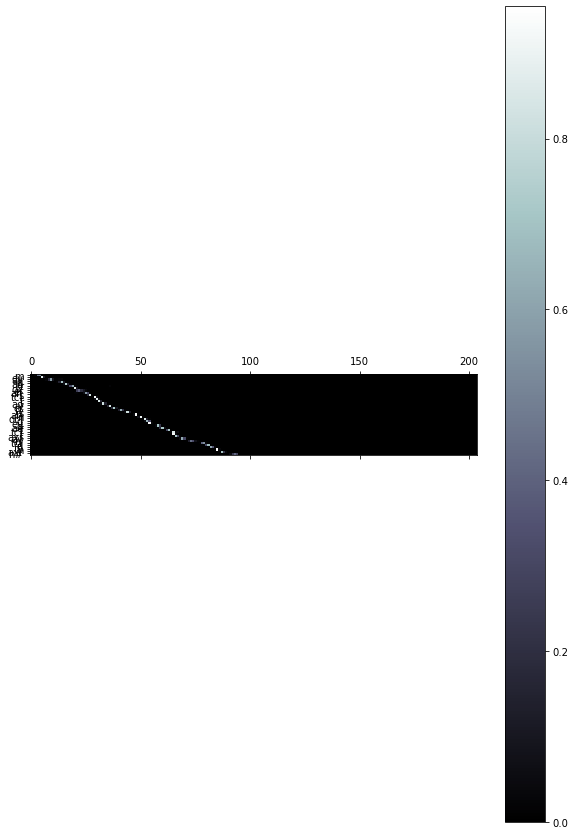

Predict:
q ix n dcl d iy v eh l ax pcl p ix ng f ih l m pau m ix n iy tcl t aa kcl k s ix kcl k eh m ax kcl k el z axr y ux z dcl d h#
Ground-truth:
h# q ix n dcl d iy v eh l ax pcl p ix ng f ih l m pau m ix n iy tcl t aa kcl k s ix kcl k eh m ax kcl k el z axr y ux z dcl d h#



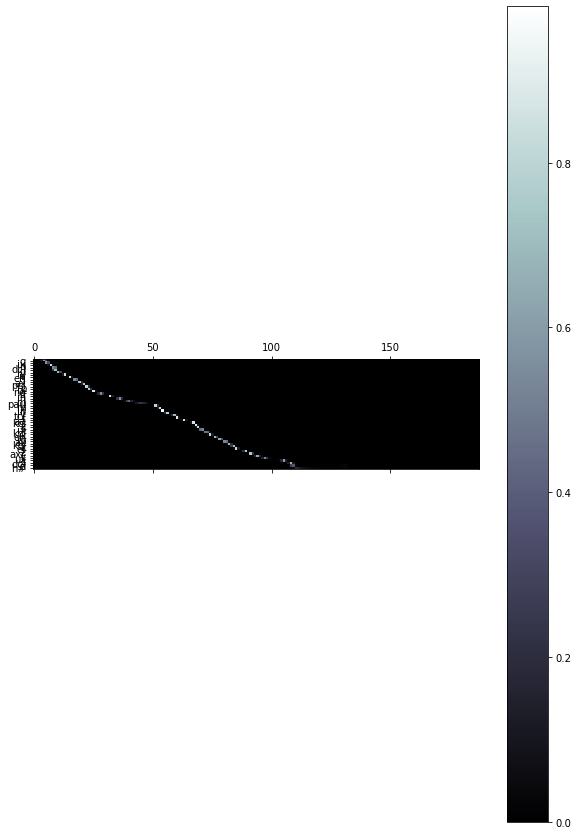

Predict:
q eh z ax pcl p axr kcl k ao sh ix n dh iy aw q l ao z bcl b ao tcl g ah n pcl p ay dx axr f ax dh axr s tcl t r ao ng hv ow l dcl d h#
Ground-truth:
h# q ae z ax pcl p axr kcl k ao sh ix n dh iy aw q l ao z bcl b ao tcl g ah n pcl p aw dx axr f ax dh axr s tcl t r ao ng hv ow l dcl d h#



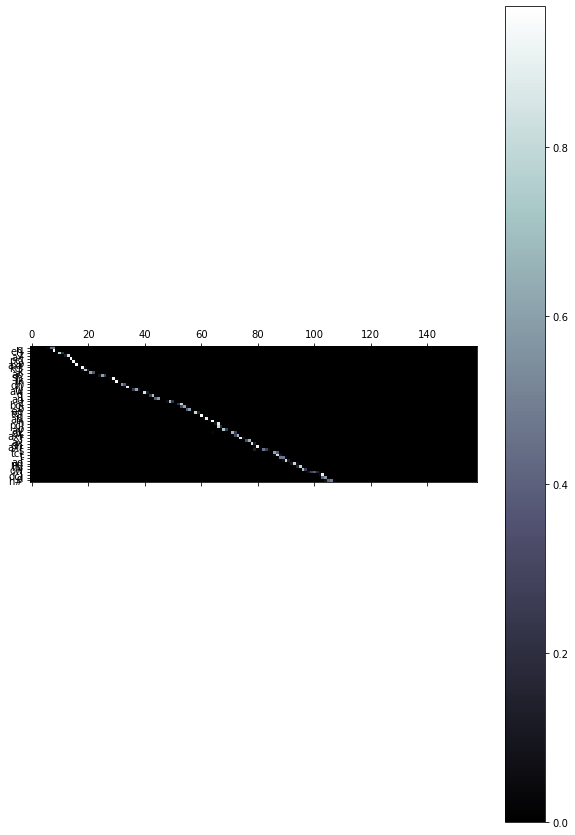

In [18]:
# Inference
with torch.no_grad():
    for (x, xlens, y) in train_loader:
        predictions, attentions = model(x.cuda(), xlens)
        predictions, attentions = predictions[0], attentions[0]
        predictions = tokenizer.decode(predictions)
        attentions = attentions[:len(predictions.split())].cpu().numpy()   # (target_length, source_length)
        ground_truth = tokenizer.decode(y[0])
        print ("Predict:")
        print (predictions)
        print ("Ground-truth:")
        print (ground_truth)
        print ()
        showAttention(predictions, attentions)

In [19]:
epoch = 0
with open('config/default/timing.csv', 'w') as filehandle:
    for (train_epoch_duration, eval_epoch_duration, RMSE) in zip(train_epoch_durations, eval_epoch_durations, RMS):
        msg = '%d, %s, %s, %s \n' % (epoch, train_epoch_duration, eval_epoch_duration, RMSE)
        #print(msg)
        epoch = epoch +1 
        filehandle.write(msg)